In [38]:
# -*- coding: utf-8 -*-
# Packages -----------------
import os
import sys
import shutil
import warnings
import datetime

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pedophysics import predict, Soil
import FDEM
from FDEM import Initialize
from plots import *

from scipy import constants
from utils.spatial_utils import utm_to_epsg, get_coincident, get_stats_within_radius
from utils.profile_utils import merge_layers, plot_profile, check_uniformity_and_interpolate

from PyPDF2 import PdfMerger
#!pip install tensorflow
sys.path.insert(0,'../src/') # this add the emagpy/src directory to the PATH
from emagpy import Problem
pd.set_option('display.max_columns', None)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
s_site = 'P'

# Parameters
cl = 0.3       # 0.2, 0.3, 0.4
percent = 20   # 10, 20, 30
# Inversion parameters
sample_loc = 'mean' # 'mean' or 'closest'
FM = 'FSeq' #'CS', 'FSlin' or 'FSeq'
MinM = 'Gauss-Newton'  
alpha = 0.07
remove_coil = False
start_avg = True
constrain = False

In [40]:
# User input

only_samples = False

# Define input datatype and source folder
datafolder = 'data' # data folder
datafolder_ERT = 'data/ERT'
em_intype = 'rec'   # 'rec' = rECa transect; 'lin' = LIN ECa transect; 
                    # 'survey' = rEC full survey

config = {}
config['FM'] = FM #'CS', 'FSlin' or 'FSeq'
config['MinM'] = MinM
                                        # mMinimize = ['L-BFGS-B','TNC','CG','Nelder-Mead'] --> https://docs.scipy.org/doc/scipy/reference/optimize.html 
                                        # mMCMC = ['ROPE','DREAM', 'MCMC'] # ??? 'SCEUA' ??? --> https://spotpy.readthedocs.io/en/latest/ 
                                        # mOther = ['ANN','Gauss-Newton','GPS'] (ANN requires tensorflow)
config['alpha'] = alpha
config['remove_coil'] = remove_coil    # set to True if you want to remove coils in the inversion process
# Reference profile for starting model (conductivity values)
config['start_avg'] = start_avg     # take average of input resistivity profiles per layer as starting model
                                # if false, reference profile is taken as starting model
config['constrain'] = constrain

# Sensor settings
config['instrument_code'] = 'Dualem-21HS' # instrument code
config['instrument_height'] = 0.165     # instrument height
config['instrument_orientation'] = 'HCP'    # instrument orientation
config['regularization'] = 'l2'

# Remove coils for inversion?
                                
if s_site == 'P':
    config['coil_n'] = [0, 1]    # indexes of coils to remove (cf. emagpy indexing)
                                # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                                # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

    config['bounds'] = [(10, 55), (20, 120), (50, 335), (50, 250), (10, 50)] 

    config['reference_profile'] = 15 # ID of ERT (conductivity) profile to be used 
                                 #  to generate starting model
                                 # For proefhoeve nr 15 is used, for middelkerke 65

    n = 4

elif s_site == 'M':
    config['bounds'] = [(5, 80), (50, 380), (76, 820), (100, 1000), (150, 1000)]

    config['coil_n'] = [4, 5]    # indexes of coils to remove (cf. emagpy indexing)
                                # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                                # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

    config['reference_profile'] = 65 # ID of ERT (conductivity) profile to be used 
                                    #  to generate starting model
                                    # For proefhoeve nr 15 is used, for middelkerke 65
    n = 4

# Define the interfaces depths between layers for starting model and inversion
#           (number of layers = len(config['interface'])+1)
config['n_int'] = True # if True custom interfaces are defined (via config['interface']), 
                        # otherwise reference profile interfaces are used
config['interface'] = [0.1, 
                       0.2, 
                       0.3, 
                       0.4, 
                       0.5, 
                       0.6, 
                       0.7, 
                       0.8,
                       0.9, 
                       1, 
                       1.2, 
                       1.5, 
                       2.0,
                       2.5,
                       3]

# [0.1, 0.5, 2.0 ] # depths to custom model interfaces
# [0.3, 0.6, 1.0, 2.0 ] # depths to custom model interfaces
# Inversion constraining
# if constrained inversion is used, you can set custom EC bounds (and other params)
'''
    config['bounds'] is the 'bnds' used in emagpy constraining
    if you fix 2 interface and fit 3 layer EC:
    [(layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    If you fit 2 interfaces and fit 3 layer EC:
    [(int1_min, int1_max), 
    (int2_min, int2_max), 
    (layer1_ec_min, layer1_ec_max), 
    (layer2_ec_min, layer2_ec_max), 
    (layer3_ec_min, layer3_ec_max)]

    autobounds MDK:[(22.877321099166068, 83.29767890083818), 
    (50.6150000000018, 381.79940055200086), 
    (75.5445000000012, 819.2347232074701), 
    (124.346000000001, 1108.1655185859772), 
    (188.4700000000009, 1025.8167426267287)]   
'''

config['custom_bounds'] = True

# !!! ---

# [  6.  43.]
#  [ 27. 183.]
#  [ 36. 307.]
#  [ 63. 335.]
#  [ 47. 337.]
#  [ 82. 224.]
#  [ 53. 103.]
#  [ 39.  73.]

if config['n_int'] == False and config['custom_bounds']:
    print('Check if bounds and number of interfaces match')

# Geographic operations (if needed)
c_transform = False
c_utmzone = '31N'
c_target_cs = 'EPSG:31370'

# remove profiles at transect edges
config['n_omit'] =  10 # number of profiles to exclude from the start
                       # and end of the ERT transect (none = 0) for the inversion
                       # a total of 60 profiles is available, for middelkerke
                       # 120 profiles are available  

# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    config['instrument_code'] == 'Dualem-21HS'
    emfile_prefix = 'proefhoeve_21HS'
    #else: 
    #    emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'
inv_folder = os.path.join(datafolder, 'inverted')
os.makedirs(inv_folder, exist_ok=True) 
cal_folder = os.path.join(datafolder, 'calibrated')
ert_file = os.path.join(datafolder_ERT, f'{profile_prefix}-inv-ERT-{cl}_{percent}.csv')
em_rec = os.path.join(cal_folder, f'{emfile_prefix}_raw_transect_calibrated_rECa_{cl}_{percent}.csv')
em_lin = os.path.join(cal_folder,f'{emfile_prefix}_raw_transect_calibrated_{cl}_{percent}.csv')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_raw_calibrated_rECa_{cl}_{percent}.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samp_locations.csv')

if em_intype == 'rec':
    infile = em_rec
elif em_intype == 'survey':
    infile = em_survey
else:
    infile = em_lin

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                    instrument_orientation=config['instrument_orientation']
                                    )

# Column names for emapgy input
emp_21HS = [f"HCP0.5f9000{config['instrument_height']}", 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165',
            'HCP0.5f9000h0.165_inph', 'PRP0.6f9000h0.165_inph', 'HCP1.0f9000h0.165_inph',
            'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph'
            ]

emp_421S = ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165', 
            'HCP1.0f9000h0.165_inph', 'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph',
            'HCP4.0f9000h0.165_inph', 'PRP4.1f9000h0.165_inph'
            ]

if config['MinM'] == 'Gauss-Newton':
    config['regularization'] = 'l2'

# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

# 1.0 Data import and structuring into dataframe
ert_p = pd.read_csv(ert_file, sep=',', header=0)
em_rec = pd.read_csv(em_rec, sep=',', header=0)
em_lin = pd.read_csv(em_lin, sep=',', header=0)
em_survey = pd.read_csv(em_survey, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)

if c_transform:
    # Create a new filename with the target EPSG code
    em_rec = utm_to_epsg(em_rec, c_utmzone, target_epsg=c_target_cs)
    em_lin = utm_to_epsg(em_lin, c_utmzone, target_epsg=c_target_cs)
    em_survey = utm_to_epsg(em_survey, c_utmzone, target_epsg=c_target_cs)

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                        instrument_orientation=config['instrument_orientation']
                                        )

if sample_loc == 'closest':
    em_samples = get_coincident(em_survey, samples)
    #path_sample_loc = os.path.join('data/inverted', f'{profile_prefix}_em_samples_{cl}_{percent}_{sample_loc}.csv')
    #em_samples.to_csv(path_sample_loc)

elif sample_loc == 'mean':
    if s_site == 'P':
        em_samples = get_stats_within_radius(em_survey, samples, 1)
        #path_sample_loc = os.path.join('data/inverted', f'{profile_prefix}_em_samples_{cl}_{percent}_{sample_loc}.csv')
        #em_samples.to_csv(path_sample_loc)

    elif s_site == 'M':
        em_samples = get_stats_within_radius(em_survey, samples, 2)
        #path_sample_loc = os.path.join('data/inverted', f'{profile_prefix}_em_samples_{cl}_{percent}_{sample_loc}.csv')
        #em_samples.to_csv(path_sample_loc)

# ---------------------------------------------------------------------------- #
# Get ERT profiles
# ---------------- #
# Group the data by profile ID for efficient access to each profile
profiles = ert_p.groupby('ID')

# Exclude the first and last n_omit profiles
unique_ids = ert_p['ID'].unique()

if config['n_omit'] == 0:
    ert_final = ert_p.copy()
else:
    if config['n_omit']*2 >= len(unique_ids):
        warnings.warn('!!! You removed all profiles !!! Change value for config[n_omit]')
        raise KeyboardInterrupt
    else:
        selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
        ert_p = ert_p.loc[ert_p['ID'].isin(selected_ids)]
        ert_final = ert_p.copy()

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest

# convert resistivity to conductivity and modify column names

ert_final[dataset_name] = (1/ert_final[dataset_name])
dc_corr = ert_final.copy()
dc_corr[dataset_name] = predict.BulkEC(Soil(
                                                frequency_ec = 9000,
                                                bulk_ec_dc = dc_corr[dataset_name].values
                                                ))

ert_final.loc[:, dataset_name] = ert_final[dataset_name]*1000
dc_corr.loc[:,dataset_name] = dc_corr[dataset_name]*1000
ert_final = ert_final.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})
dc_corr = dc_corr.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})

# ------------------------------------------------------------------------------

# Columns containing the resistivity data
data_column = ['EC(mS/m)']
# Assuming ert_final is your DataFrame with profile data
all_profiles_df, uniform_intervals = check_uniformity_and_interpolate(
    dc_corr, 'ID', 'Z', *data_column
)

dataset_name = 'EC(mS/m)'  # The variable of interest
# #Plotting combined profiles
# plot_combined_profiles(ert_final, all_profiles_df, 
#                        data_column, compare_name = data_column)
#

data_query [[107719.853 183326.516]
 [107755.838 183331.095]
 [107797.963 183278.886]
 [107764.388 183318.416]
 [107723.617 183309.551]
 [107742.174 183329.651]
 [107806.339 183274.885]
 [107758.704 183312.634]
 [107775.993 183310.289]
 [107726.74  183319.096]
 [107766.796 183327.428]
 [107777.193 183299.459]
 [107751.848 183298.452]
 [107732.833 183327.555]
 [107776.559 183291.247]]
idx, point 0 [107719.853 183326.516]
indices [5106, 5109, 5110, 5111, 5112, 5113, 5114, 5108, 5107]
idx, point 1 [107755.838 183331.095]
indices [19203, 19204, 19205, 19182, 19183, 19184, 19185, 19186, 19187, 19188, 19189, 19190, 19191, 19192, 19193, 19194, 19195, 19196, 19197, 19198, 19199, 19200, 19201, 19202, 19992, 19991, 19990, 19989, 19179, 19180, 19181, 19994, 19993]
idx, point 2 [107797.963 183278.886]
indices [22304, 22303, 22302, 22306, 22307, 22308, 22305, 22468, 22469, 22470, 22471]
idx, point 3 [107764.388 183318.416]
indices [19297, 19298, 19299, 19300, 19301, 19302, 19303, 19304, 19935, 1993

<Figure size 1000x800 with 0 Axes>

all_profiles_df         Z  EC(mS/m)    ID     easting    northing
0    -4.2   37.1210  11.0  107763.916  183306.477
1    -4.1   39.4840  11.0  107763.916  183306.477
2    -4.0   40.1545  11.0  107763.916  183306.477
3    -3.9   40.8250  11.0  107763.916  183306.477
4    -3.8   41.8820  11.0  107763.916  183306.477
...   ...       ...   ...         ...         ...
1677 -0.5   76.3970  50.0  107774.877  183290.349
1678 -0.4   53.1890  50.0  107774.877  183290.349
1679 -0.3   39.8750  50.0  107774.877  183290.349
1680 -0.2   33.1005  50.0  107774.877  183290.349
1681 -0.1   26.3260  50.0  107774.877  183290.349

[1682 rows x 5 columns]
new_int [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.5, 2.0, 2.5, 3]


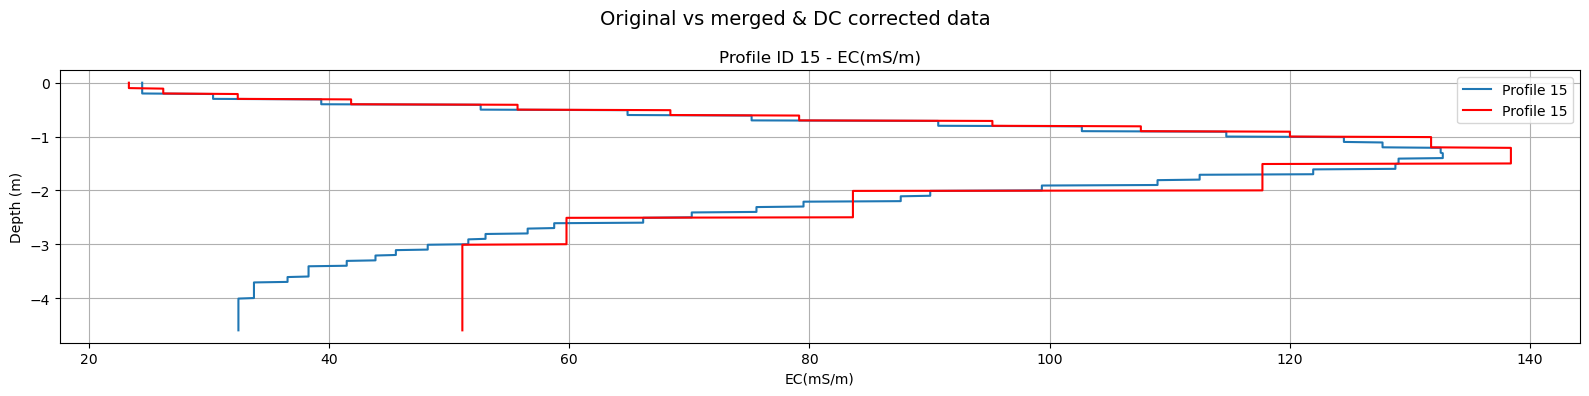

In [41]:
# config['reference_profile'] = 11
pd.set_option('display.max_columns', None)

if config['reference_profile'] not in all_profiles_df['ID'].unique():
    warnings.warn("Warning: the reference profile ID does not exist. Provide correct profile ID.")
    raise KeyboardInterrupt
else:
    profile_id = config['reference_profile']

# Create new layer configuration for prior model based on ERT data
if config['n_int']:
    new_int = config['interface']
    print('all_profiles_df', all_profiles_df)
    print('new_int', new_int)
    merged_df = merge_layers(all_profiles_df, new_int,'EC(mS/m)')
else:
    merged_df = all_profiles_df
comparedf = merged_df.copy()

# Plot original and (merged and) DC corrected reference profile
if config['n_int']:
    plot_title = 'Original vs merged & DC corrected data'
    first_in = .1
else: 
    plot_title = 'Original vs DC corrected data'
    first_in = .0
ert_eval = ert_final.copy()
ert_eval['Z'] = ert_eval['Z'].values + first_in

plot_profile(ert_eval, profile_id, dataset_name, compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', block=True, plot_title=plot_title)

# Get prior model info
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = abs(group[depth_col].diff().iloc[1])
        #print(uniform_interval)
        num_layers = len(group[res_col])
                # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        con = group[res_col].values/1000
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)
        sus = np.zeros(num_layers)
        # Create model instance
        M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

models = generate_forward_model_inputs(merged_df, 'ID', 'Z', 'EC(mS/m)')

conductivities [ 51.105   59.774   83.618  117.706  138.39   131.7465 119.995  107.586
  95.228   79.14    68.422   55.7     41.845   32.409   26.208   23.3455]


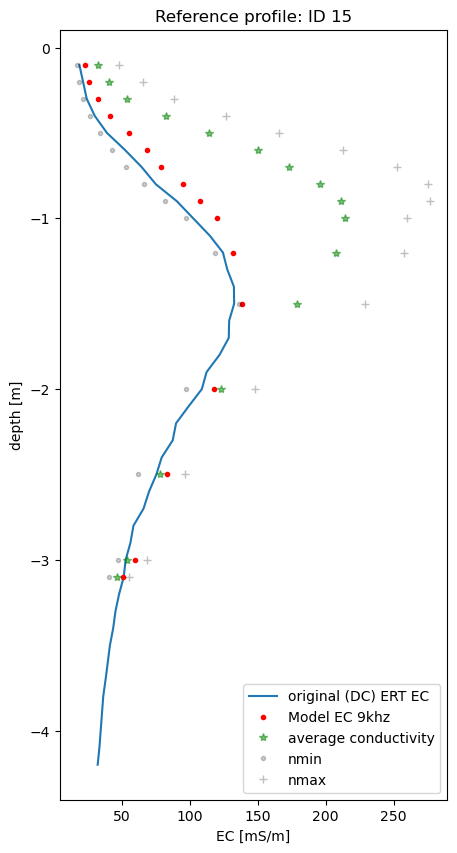

In [42]:
# 
# -------------------------------------------------------------------- #

# 
profile_data = merged_df[merged_df['ID'] == profile_id].copy()
res_col = 'EC(mS/m)'
depth = 'Z'
max_ert_depth = ert_final['Z'].abs().max()

# 
# ------------------------------------------------------------------------------

# A. Test run on the reference profile (config['reference_profile'])
#       and plot the results

if not config['n_int']:
    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)
    if first_lay == 0:
        profile_data[depth]=profile_data[depth] +second_lay
    else:
        profile_data[depth]=profile_data[depth] +first_lay
    thick = -profile_data[depth].iloc[1:].values
    #thick = -profile_data[depth].values
else:
    thick = -profile_data[depth].values

con = profile_data[res_col].values/1000
ref_len = len(con)
num_layers = len(con)
perm = np.full(num_layers, constants.epsilon_0)
sus = np.zeros(num_layers)

# # Create model instance
M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])

# ----------------------------------------------------------------------

dataset_name = 'EC(mS/m)'
layers_interfaces = np.cumsum(models[profile_id].thick)
layers_interfaces = np.insert(layers_interfaces, 0, 0)
profile_data = ert_final[ert_final['ID'] == profile_id]

fig, axr = plt.subplots(figsize=(5, 10))
axr.set_xlabel('EC [mS/m]')
axr.set_ylabel('depth [m]')
axr.plot((profile_data[dataset_name]),profile_data['Z'], label='original (DC) ERT EC',)
if not config['n_int']: 
    axr.plot(con[:-1]*1000,-thick, '.', label='Model EC 9khz',color = 'red')
else:
    axr.plot(con*1000,-thick, '.', label='Model EC 9khz',color = 'red')
axr.set_title(f'Reference profile: ID {profile_id}')

conductivities = con*1000
print('conductivities', conductivities)

ec_cols_ref = []
if 'end' in config['interface']:
    config['interface'].remove('end')
# Get conductivity stats for bounds
if config['n_int']:
    if 'end' in ec_cols_ref:
        ec_cols_ref.remove('end')
    ec_cols_ref = config['interface']
    ec_cols_ref.append('end')
    mod_layers = thick[1:]
else:
    if len(conductivities) == len(thick):
        mod_layers = thick[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(thick)+1):
        mod_layers = thick
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    else:
        raise ValueError(f"Check length of conductivities ({len(conductivities)}) and layers ({len(thick)}) arrays!!")
    
    ec_cols_ref = np.round(layers_interfaces,decimals=1).tolist()
ec_df = pd.DataFrame(columns=ec_cols_ref)

# 
for i in merged_df['ID'].unique(): 
    profile_data = merged_df[merged_df['ID'] == i].copy()
    if not config['n_int']:
        if abs(profile_data.iloc[0]['Z']) > max((list(map(abs, ec_cols_ref)))):
            #print(f'removed {profile_data.iloc[0]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[0].name)
        elif abs(profile_data.iloc[-1]['Z']) < 0.1:
            #print(f'removed {profile_data.iloc[-1]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[-1].name)
    res_col = 'EC(mS/m)'
    depth = 'Z' 
    con_m = profile_data[res_col].values
    layers_interfaces = np.cumsum(models[i].thick)
    layers_interfaces = np.insert(layers_interfaces, 0, 0)
    num_layers = len(con)
    perm = np.full(num_layers, constants.epsilon_0)
    sus = np.zeros(num_layers)

    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)

    if not config['n_int']:
        first_lay = profile_data[depth].iloc[-1].round(decimals=1)
        second_lay = profile_data[depth].iloc[-2].round(decimals=1)
        if first_lay == 0:
            profile_data[depth]=profile_data[depth] +second_lay
        else:
            profile_data[depth]=profile_data[depth] +first_lay
        thick = -profile_data[depth].iloc[1:].values
    else:
        thick = -profile_data[depth].values

    ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])

    # if a == 1:
    #     fig, ax = plt.subplots(figsize=(5, 10))
    #     ax.set_xlabel('EC [mS/m]')
    #     ax.set_ylabel('depth [m]')
    #     profile_data = ert_final[ert_final['ID'] == i]
    #     ax.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
    #     if not config['n_int']:
    #         ax.plot(con[:-1],-thick, '.', label='Model EC 9khz',color = 'red')
    #     else:
    #         ax.plot(con,-thick, '.', label='Model EC 9khz',color = 'red')
    #     ax.set_title(f'profile {i}')
    #     ax.legend()
    #     a = a +1

ec_df.reset_index(drop=True, inplace=True)

ec_stats = ec_df.describe().loc[['min', 'max', 'std', '50%', 'mean']]
ec_stats.rename(index={'50%': 'median'}, inplace=True)
ec_stats.loc['min_sd'] = ec_stats.loc['min'] - 2 * ec_stats.loc['std']
ec_stats.loc['max_sd'] = ec_stats.loc['max'] + 2 * ec_stats.loc['std']

position = -thick


# define parameters for inversion starting model
# --------------------------------------------- #

if not config['n_int']:
    minstat = np.flipud(ec_stats.loc['min'].values[1:])
    maxstat = np.flipud(ec_stats.loc['max'].values[1:])
    start_mod = ec_stats.loc['mean'].values[1:]
    boundcols = ec_cols_ref[:-1]
else:
    minstat = np.flipud(ec_stats.loc['min'].values)
    maxstat = np.flipud(ec_stats.loc['max'].values)
    start_mod = ec_stats.loc['mean'].values

axr.plot(np.flipud(start_mod),position, 
            '*', 
            label='average conductivity',
            color = 'green',
            alpha = 0.5)
axr.plot(minstat,position, 
            '.', 
            label='nmin',
            color = 'black',
            alpha = 0.2)
axr.plot(maxstat,position, 
            '+', 
            label='nmax',
            color = 'black',
            alpha = 0.25)

axr.legend()
if config['constrain']:
    if config['custom_bounds']:
        bounds = config['bounds']
    else:
        bounds = []
        for i, name in enumerate(ec_cols_ref):
            if ec_stats.loc['min_sd'][name] > 0:
                nmin = ec_stats.loc['min_sd'][name]
            elif ec_stats.loc['nmin'][name] > 0:
                nmin = ec_stats.loc['nmin'][name]
            else:
                nmin = 10
            nmax = ec_stats.loc['max_sd'][name]
            min_max = tuple([nmin,nmax])
            bounds.append(min_max)
        bounds = np.round(bounds, decimals=0)
        if not config['n_int'] and not config['custom_bounds']:
            bounds = bounds[1:]
        print(f'autobounds = {bounds}')



In [43]:
print(f'conductivities = {len(conductivities)}')
#print(f'con = {con*1000}')
print(f'thicknesses = {len(thick)}')
print(f'mod_layers = {len(mod_layers)}')

conductivities = 16
thicknesses = 16
mod_layers = 15


conductivities [ 51.105   59.774   83.618  117.706  138.39   131.7465 119.995  107.586
  95.228   79.14    68.422   55.7     41.845   32.409   26.208   23.3455]
start_mod [ 32.3856375  41.0854     54.31225    82.9932625 114.1154    149.986
 173.002775  195.667375  210.9093    213.9477125 207.704625  178.5861625
 123.3885     78.0230125  54.247075   46.64435  ]
length modlayers = 15 with 16 conductivities
Data used for inversion: ['HCP0.5f90000.165', 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165']
lengths: mod_layers = 15; con = 16


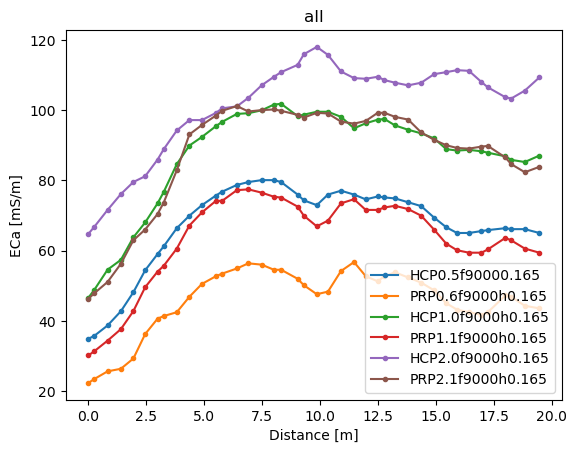

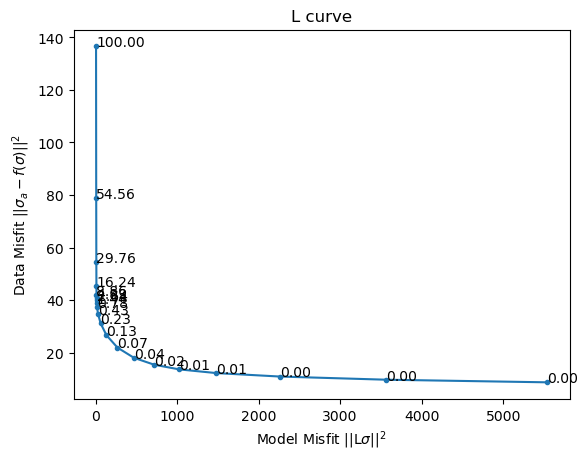

In [44]:
# FDEM inversion along ERT transect
# --------------------------------

if em_intype == 'rec':
    em_input = em_rec.copy()
elif em_intype == 'survey':
    em_input = em_survey.copy()
else:
    em_input = em_lin.copy()
print('conductivities', conductivities)

if config['start_avg']:
    print('start_mod', start_mod)
    
    conductivities = start_mod
    if len(conductivities) == len(mod_layers):
        mod_layers = mod_layers[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(mod_layers)+1):
        mod_layers = mod_layers
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")

if 'p_ID' in em_input.columns:
    em_input = em_input.rename(columns={"p_ID": "ID"})

temp_dir = 'temp_emp' 
infile_name = 'survey_input.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
em_input.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_input.columns.values[n:n+i] = new_columns

em_input.to_csv(temp_file)

# transect inversion settings
t_rec = Problem()
t_rec.createSurvey(temp_file)

t_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=np.flipud(conductivities)
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
    )
shutil.rmtree(temp_dir)

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = t_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            t_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        t_rec.removeCoil(config['coil_n'])
print(f'Data used for inversion: {t_rec.coils}')
t_rec.show()


# alphas = np.logspace(n,m,n_alph)
t_rec.lcurve()
if config['constrain']:
    print(f'lengths: mod_layers = {len(mod_layers)}; bounds =  {len(bounds)}; con = {len(conductivities)}')
else:
    print(f'lengths: mod_layers = {len(mod_layers)}; con = {len(conductivities)}')


In [45]:
if not only_samples:
    # invert using ROPE solver (RObust Parameter Estimation)
    warnings.filterwarnings('ignore')

    reg_meth = config['regularization']

    if MinM in ['MCMC', 'ROPE']:
        if config['constrain']:
            print(f'Constrained inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
            print(f'Bounds are: {bounds}')
            t_rec.invert(forwardModel=FM, 
                         method=MinM, 
                         regularization=reg_meth, 
                         alpha=alpha, 
                         bnds=bounds,
                         rep=3000,
                         njobs=-1
                        )
        else:
            print(f'Inversion using {FM} with {MinM},reg={reg_meth}, alpha={alpha}')
            t_rec.invert(forwardModel=FM, 
                         method=MinM, 
                         regularization=reg_meth, 
                         alpha=alpha, 
                         njobs=-1
                        )  

    else:
        print(f'Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
        t_rec.invert(forwardModel=FM, 
                     method=MinM, 
                     alpha=alpha,
                     regularization=reg_meth
                     )
    #t_rec.showOne2one()

Inversion using FSeq with Gauss-Newton, reg=l2, alpha=0.07
40/40 inverted

t_rec.depths[0][0] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.2 1.5 2.  2.5 3. ]


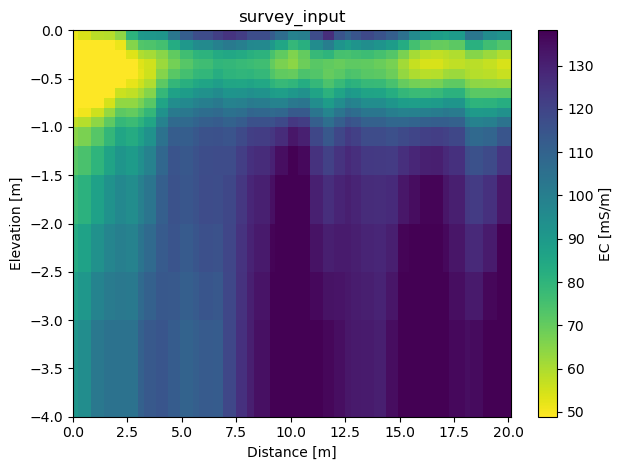

In [46]:
if not only_samples:
    # 4.1: Plot the inversion results and put outcomes into a pandas dataframe
    # ------------------------------------------------------------------------
    csv_filename = f'{emfile_prefix}_inverted_transect_{sample_loc}_{cl}_{percent}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv'

    # ******************************************************************** #

    # Plot inversion outcomes down to a max depth of 2 m, and plotting the data
    # based on their true coordinates along the transect (dist=True).
    t_rec.showResults(dist=True, errorbar = True) 
    
    print('t_rec.depths[0][0]', t_rec.depths[0][0])

    # Extracting the values from the first row of the transect.depths[0] array
    depth_values = t_rec.depths[0][0]

    # Creating the custom column names for layer_cols
    layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

    # Combining the data from the 'x', 'y' columns and the transect.models[0] array
    data = np.c_[t_rec.surveys[0].df[['x', 'y']].values, t_rec.models[0]]

    # Creating the final dataframe with the desired column names
    dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
    dt_inv['pos'] = em_input['ID']
    # ----------------------------------------------------------------------

    # Export the dataframe as a csv-file
    outfile_transect = os.path.join(inv_folder, csv_filename)
    dt_inv.to_csv(outfile_transect)

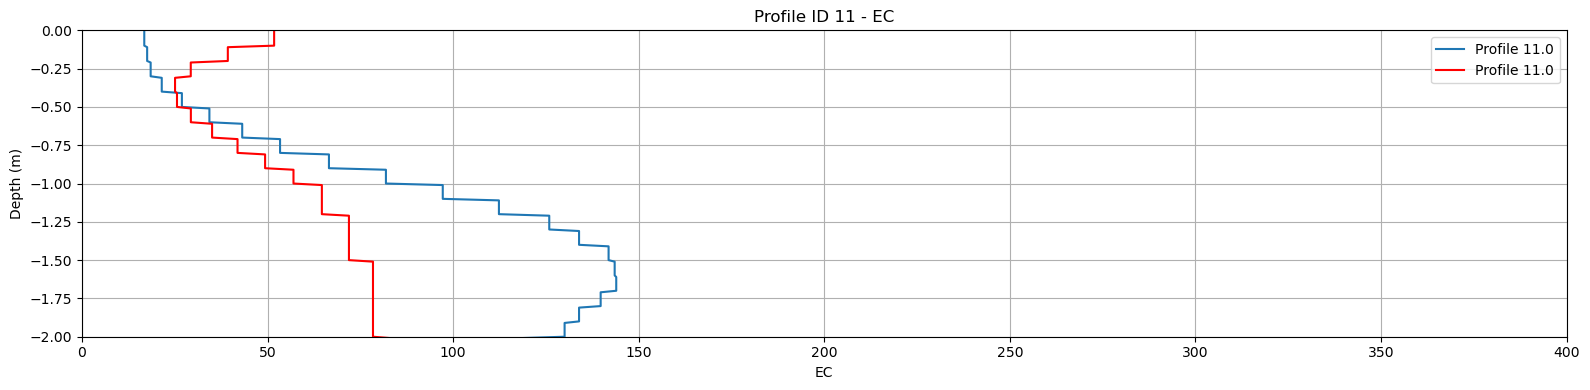

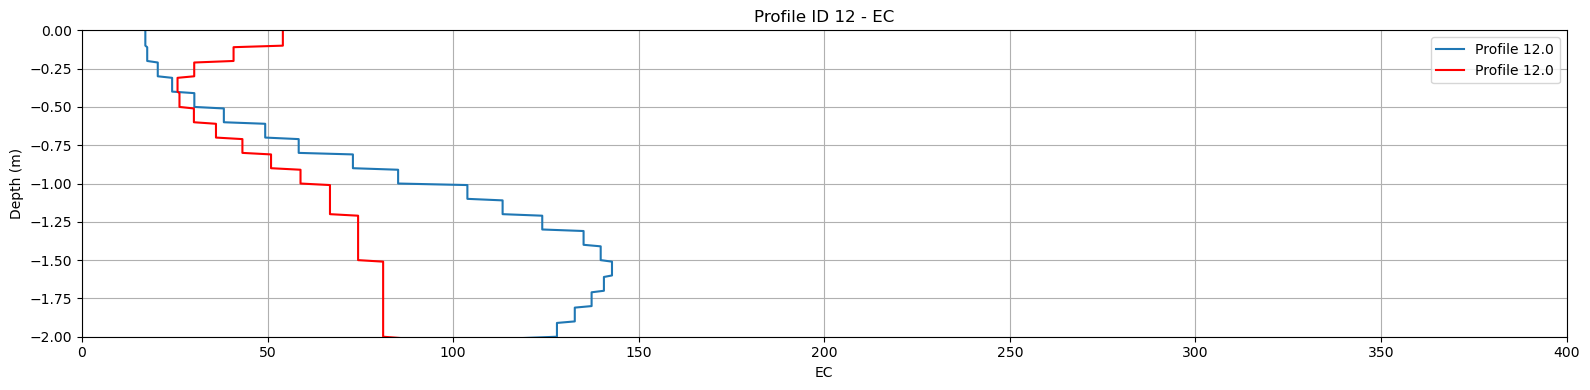

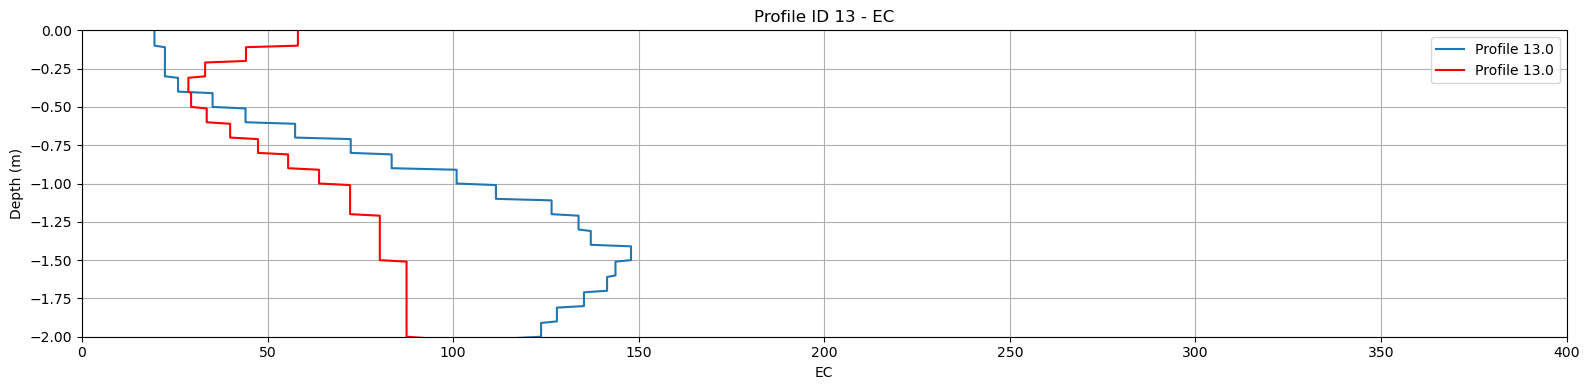

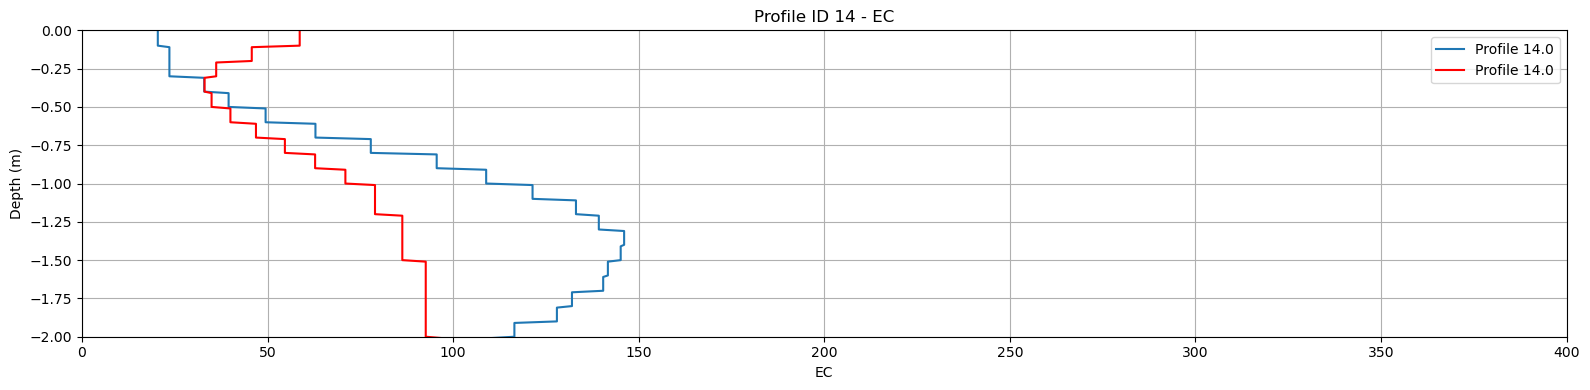

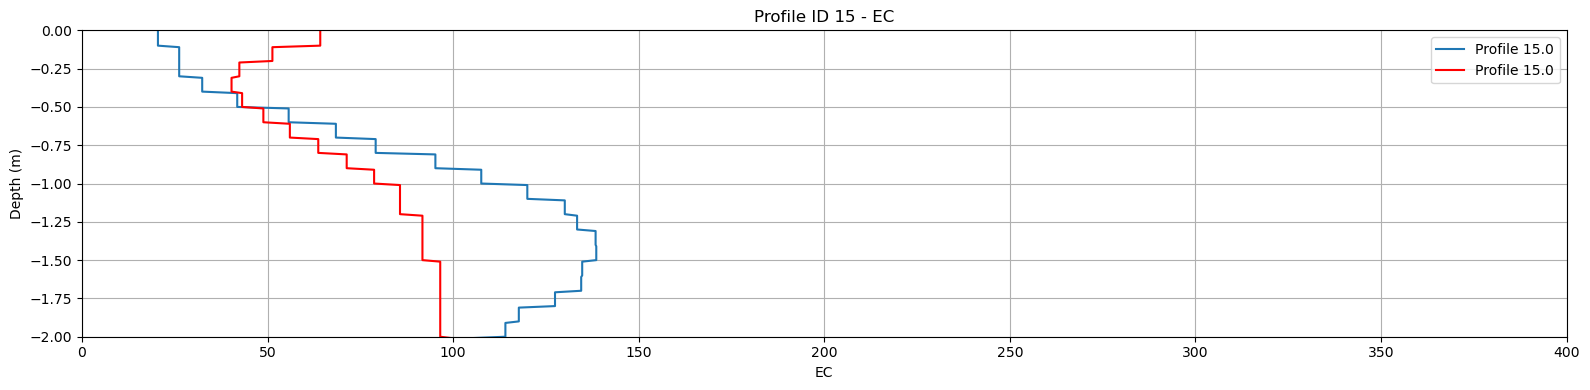

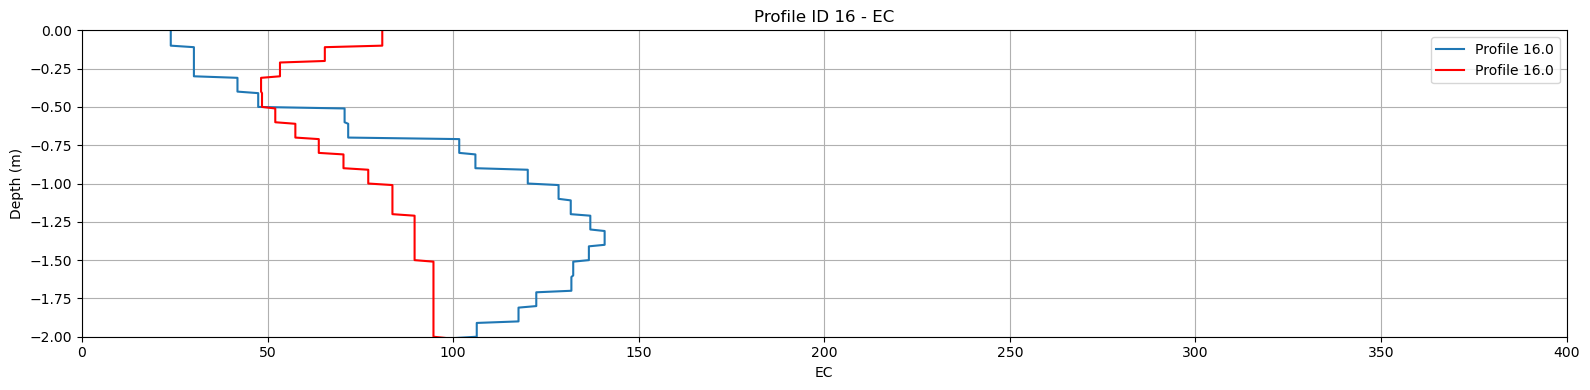

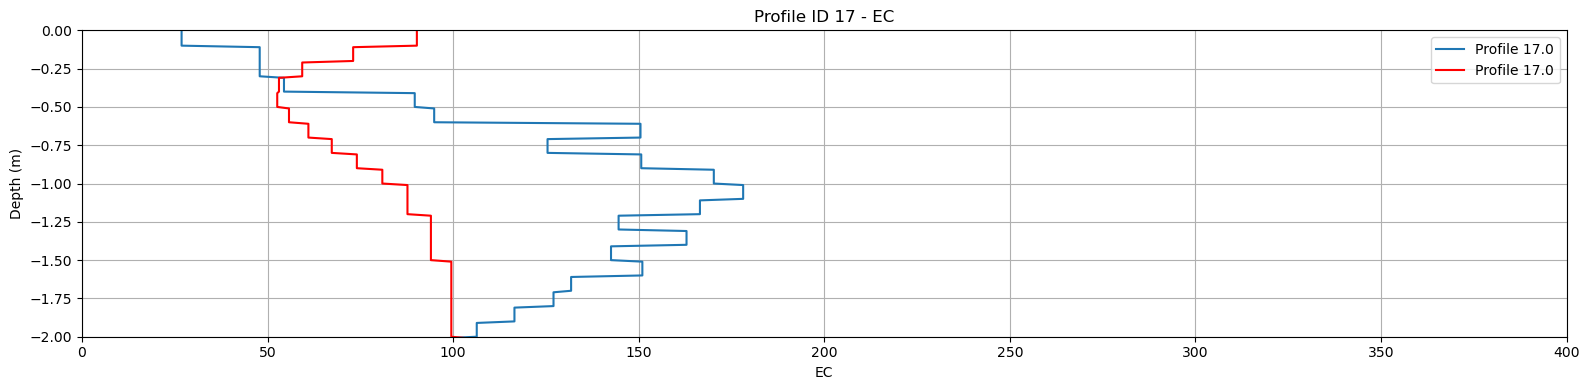

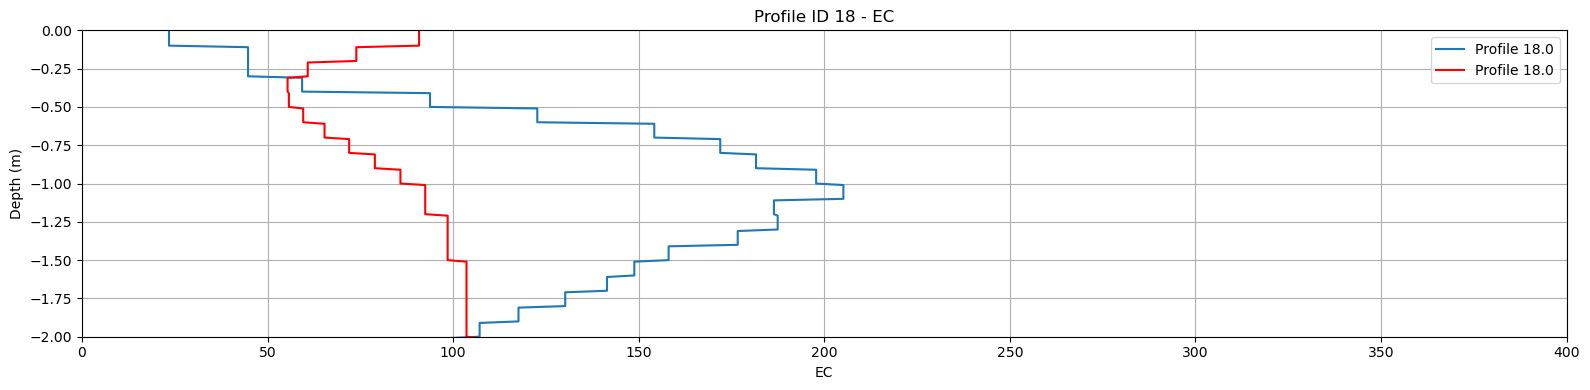

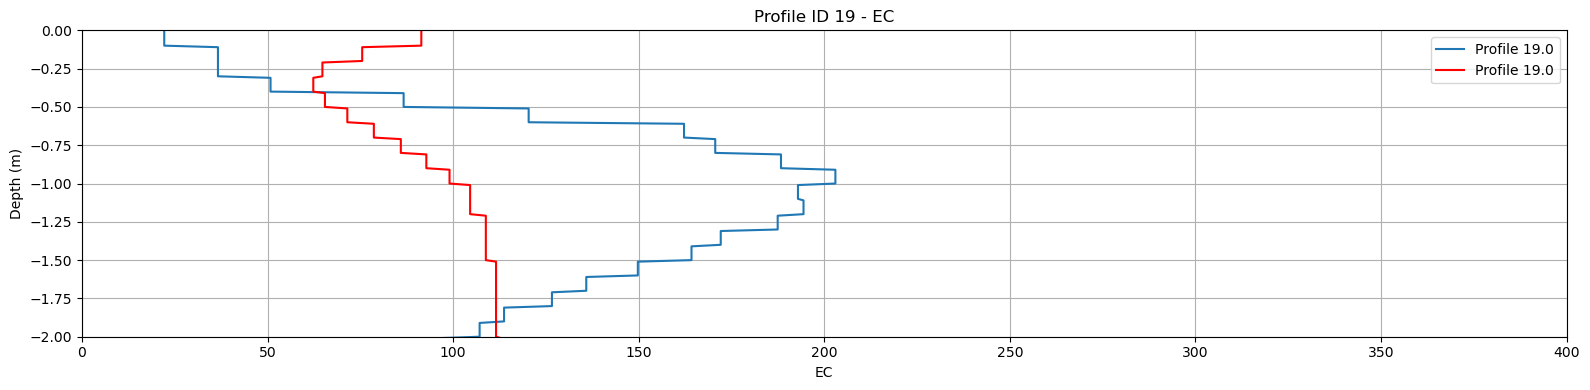

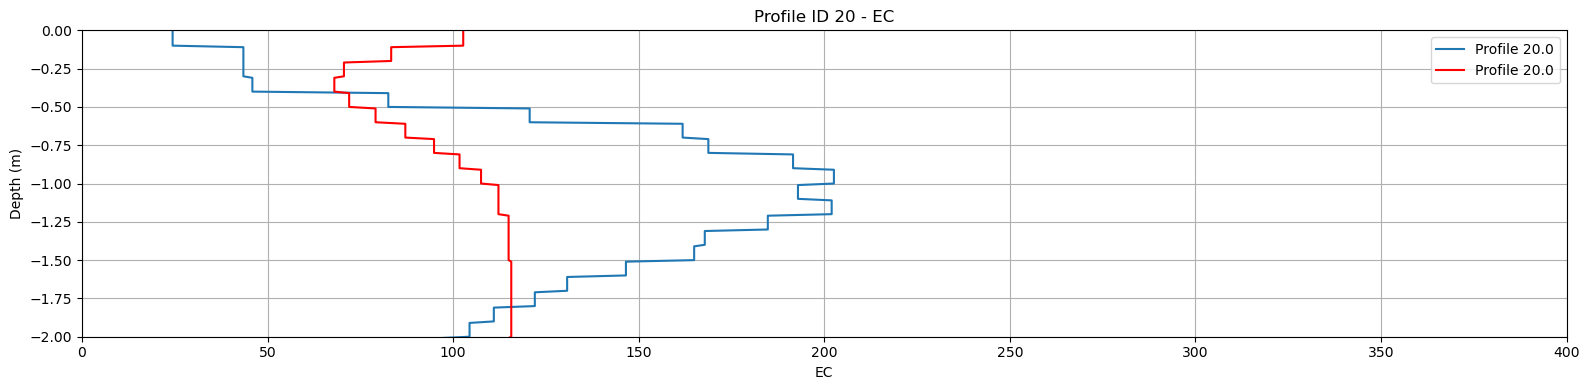

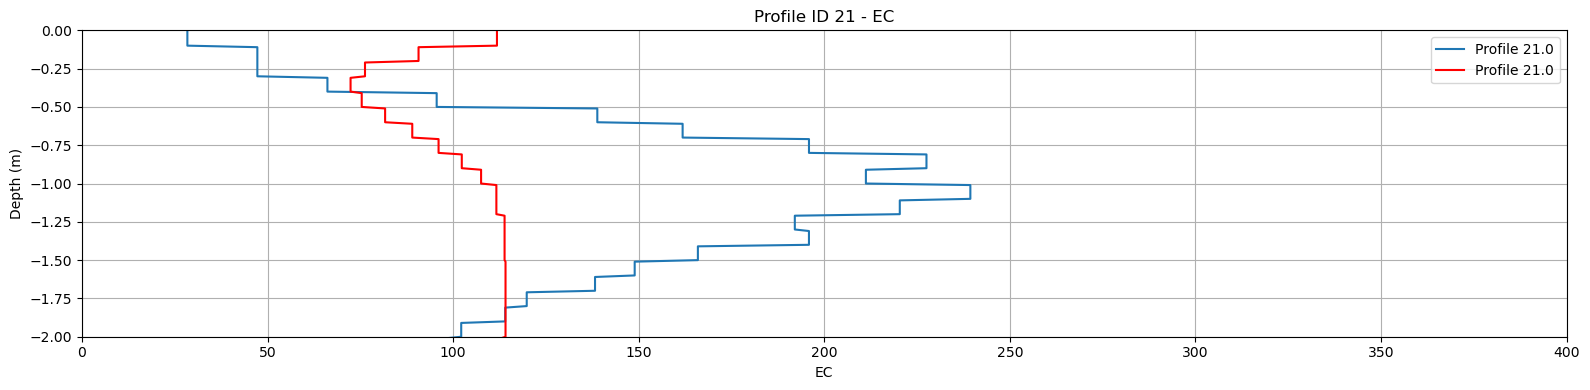

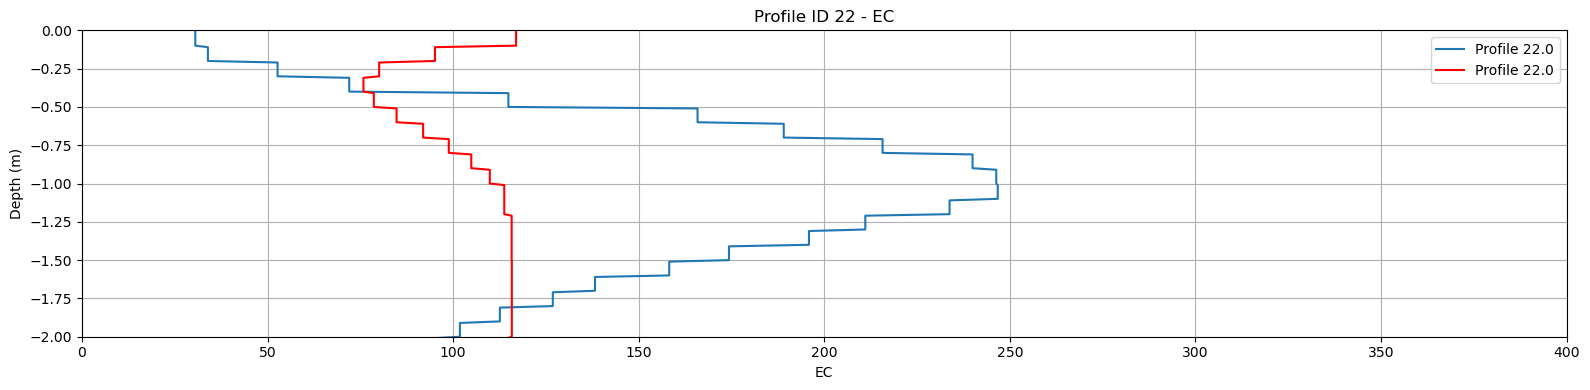

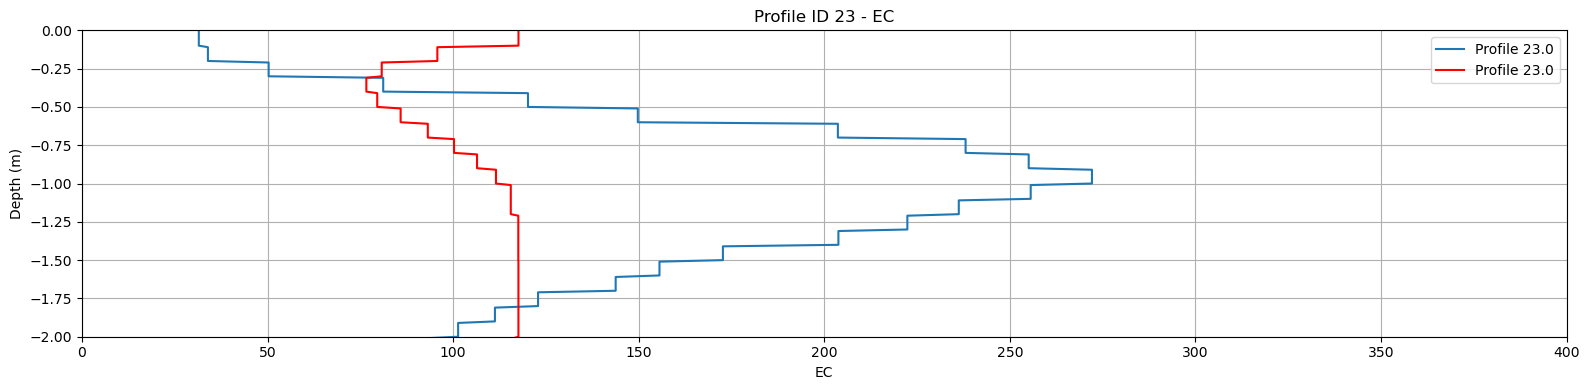

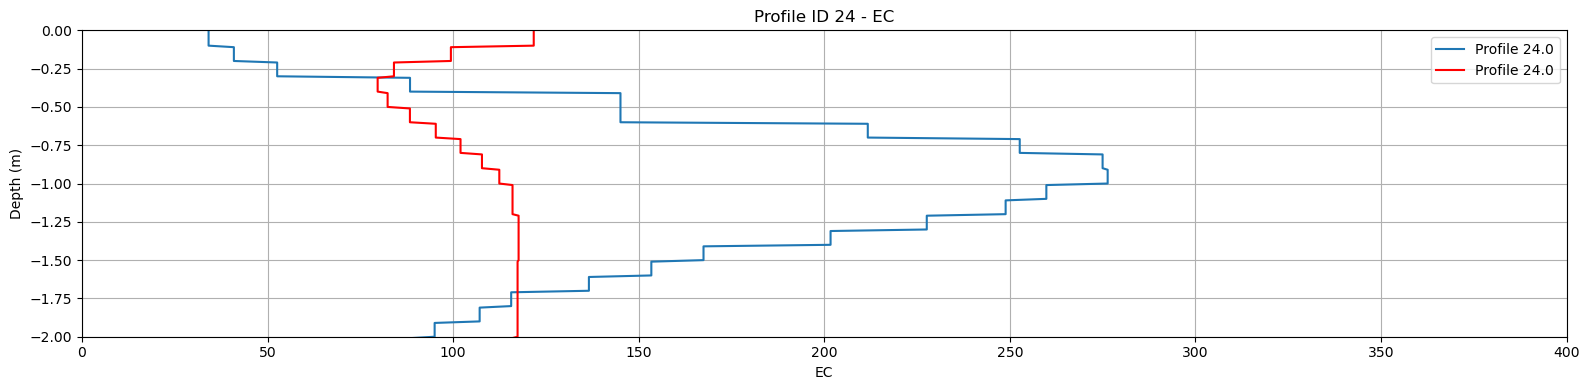

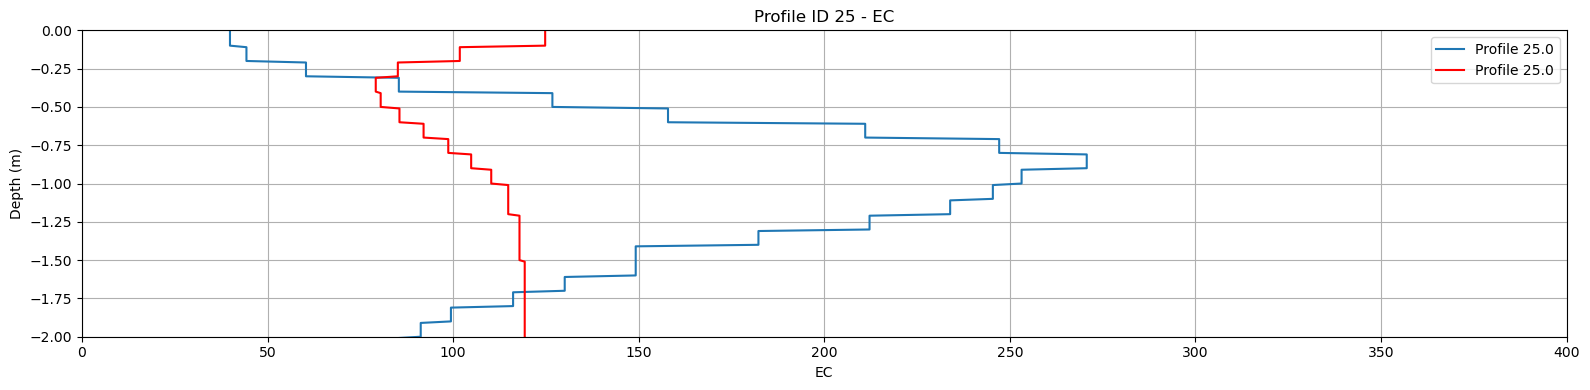

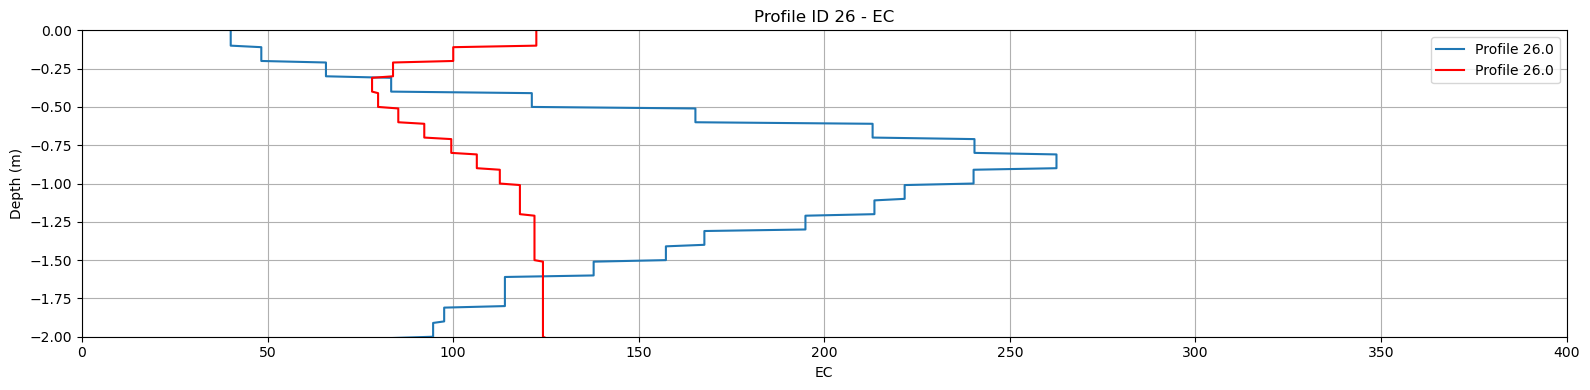

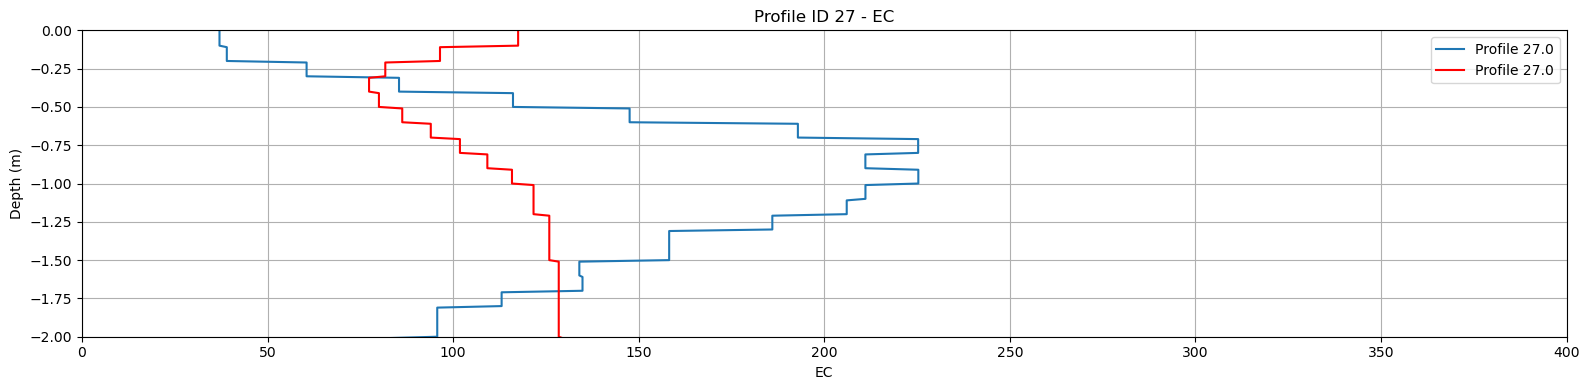

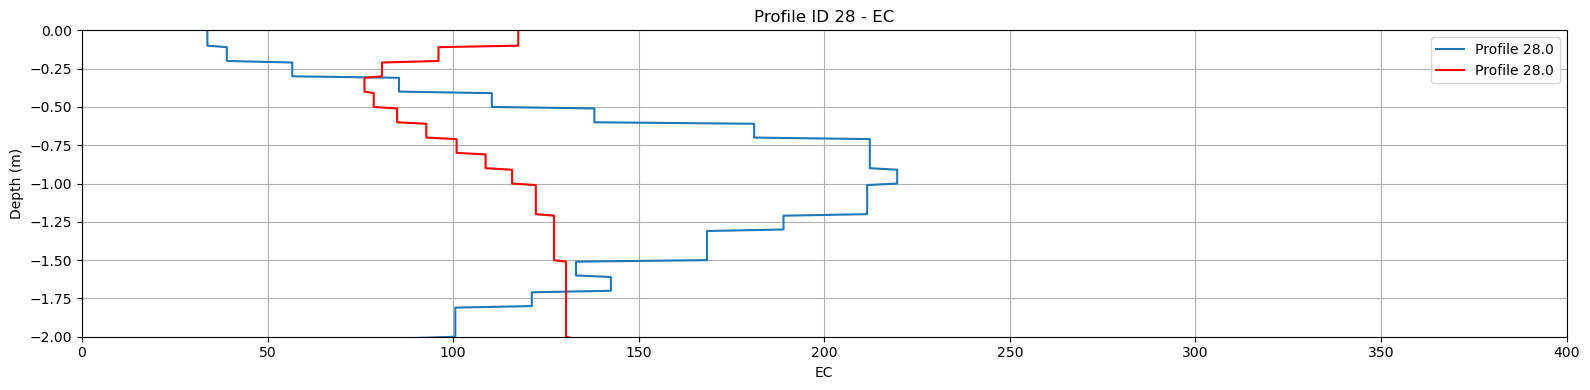

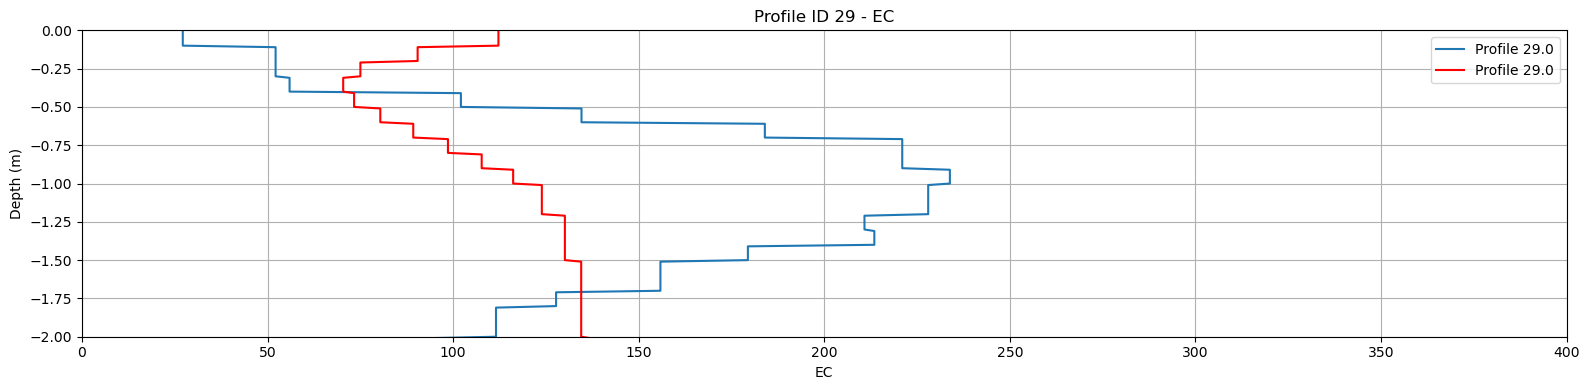

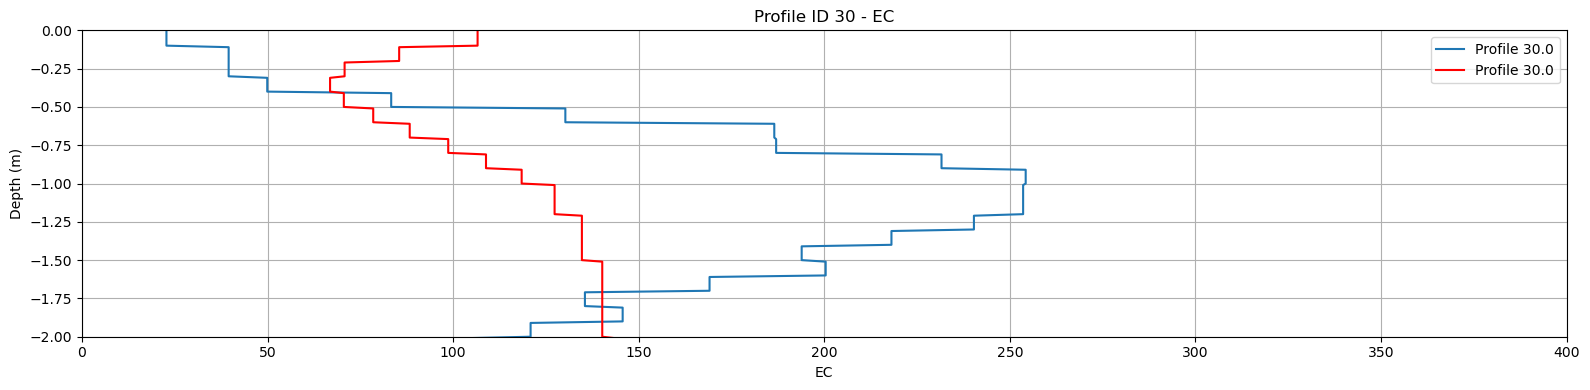

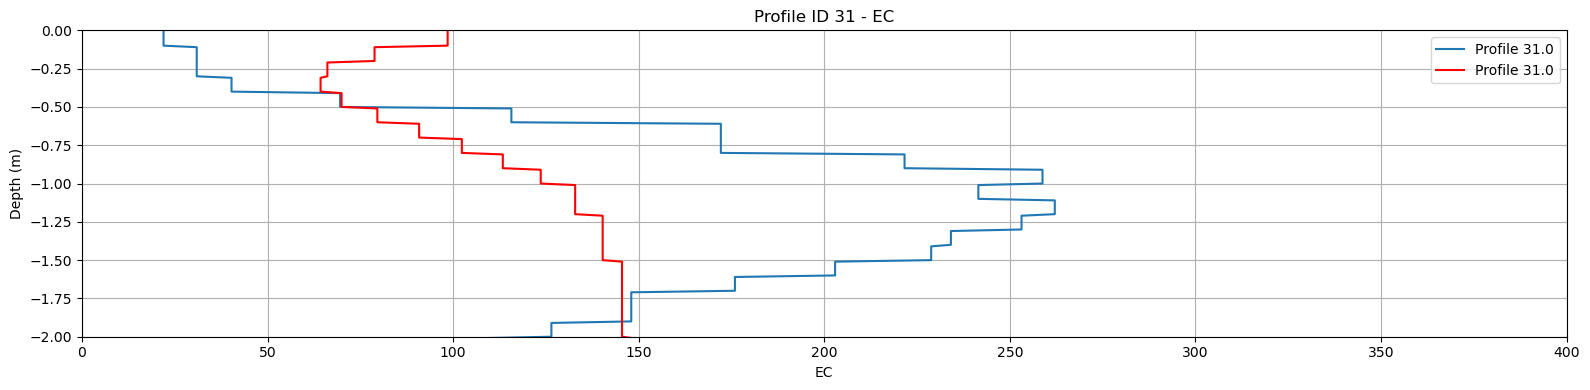

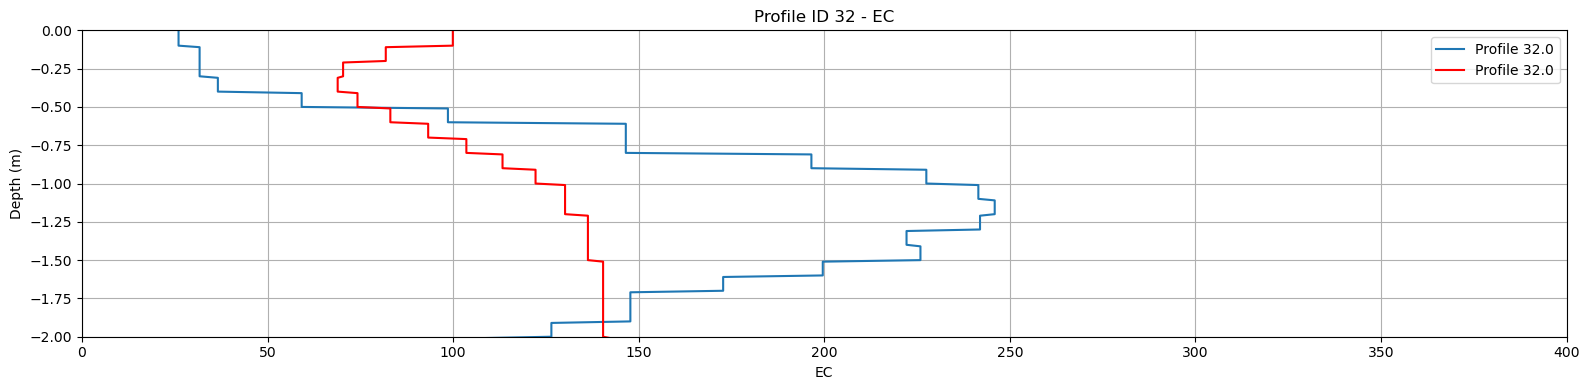

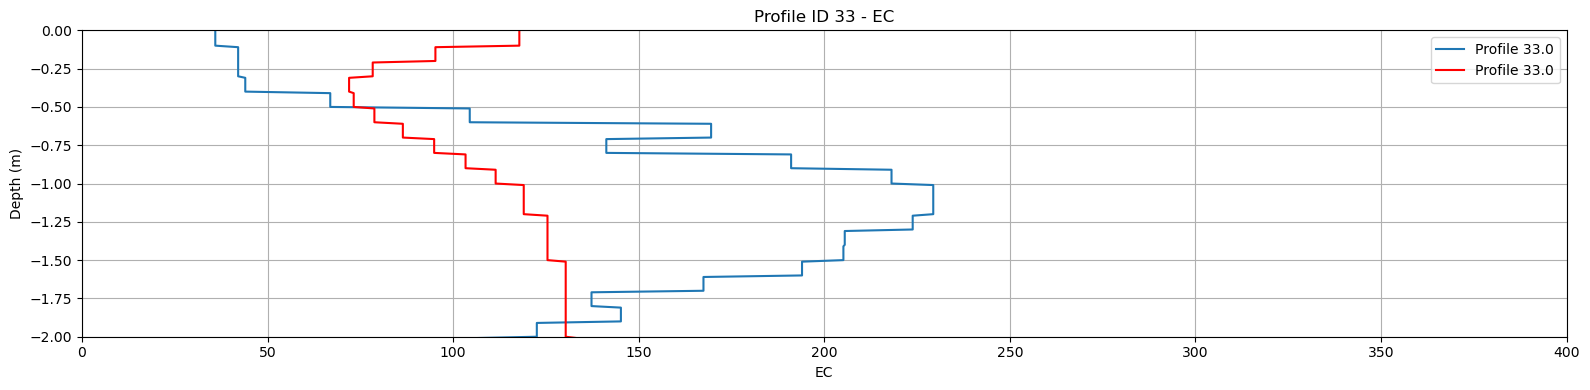

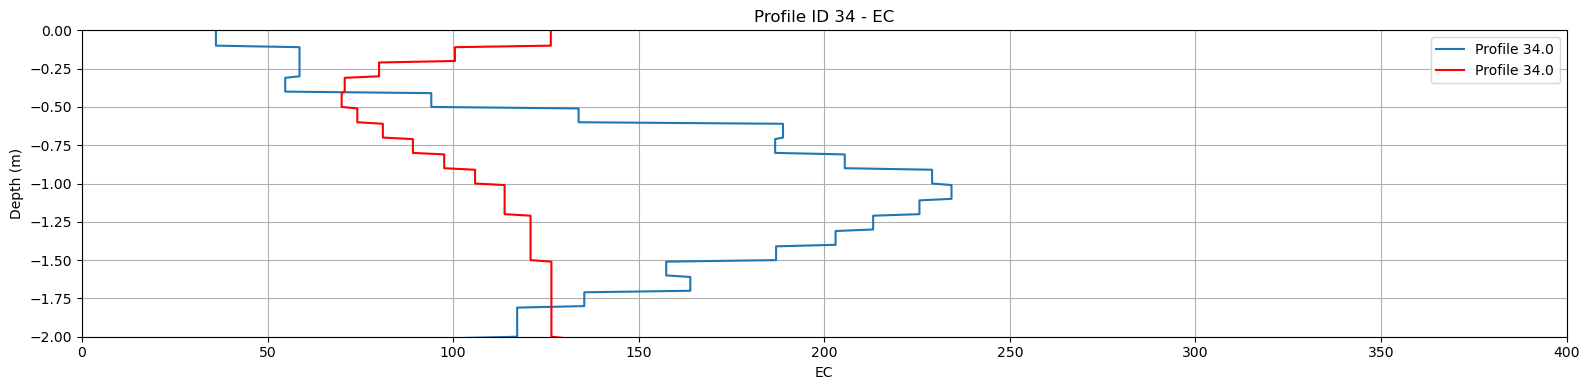

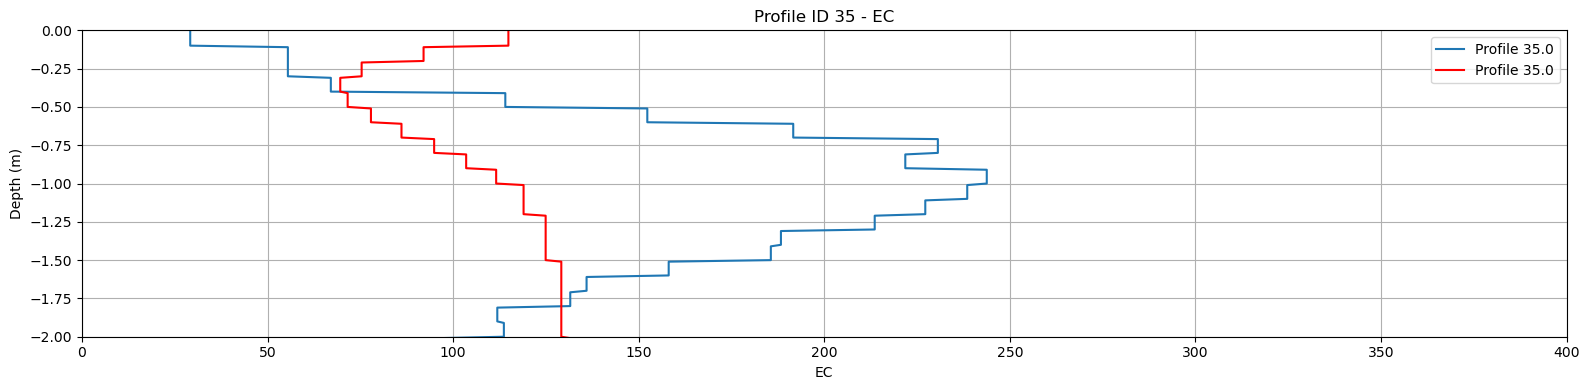

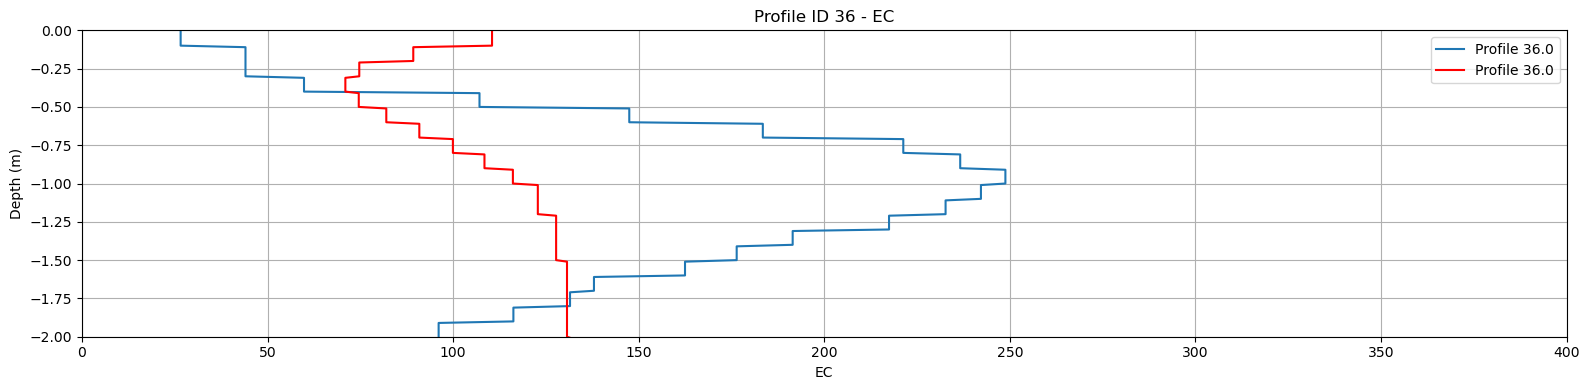

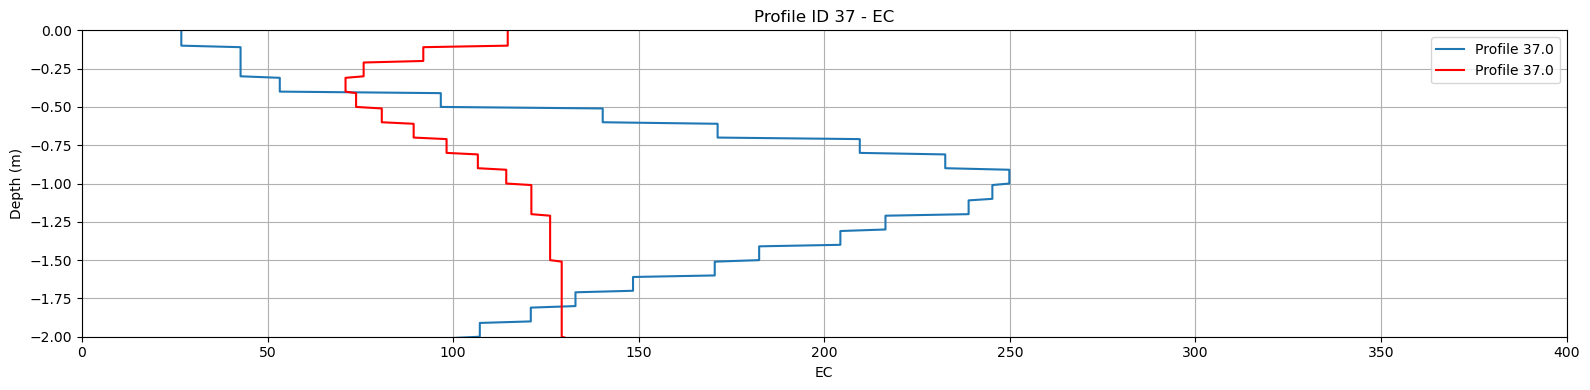

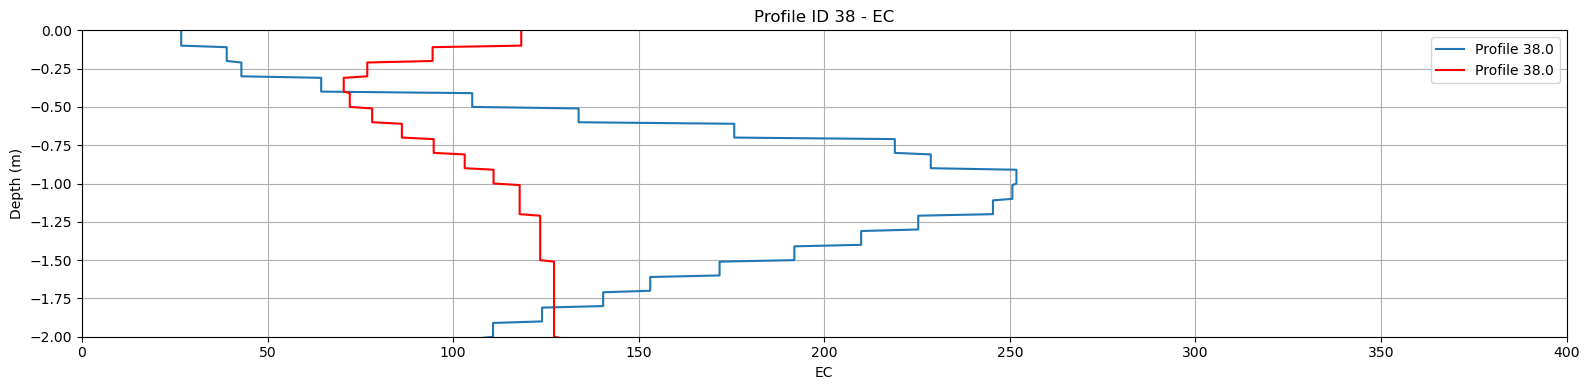

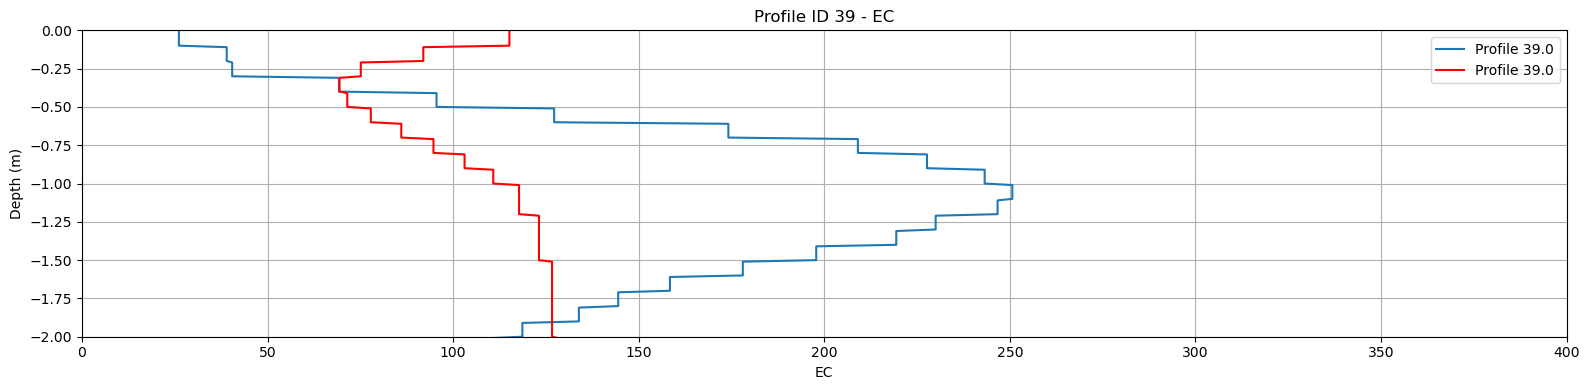

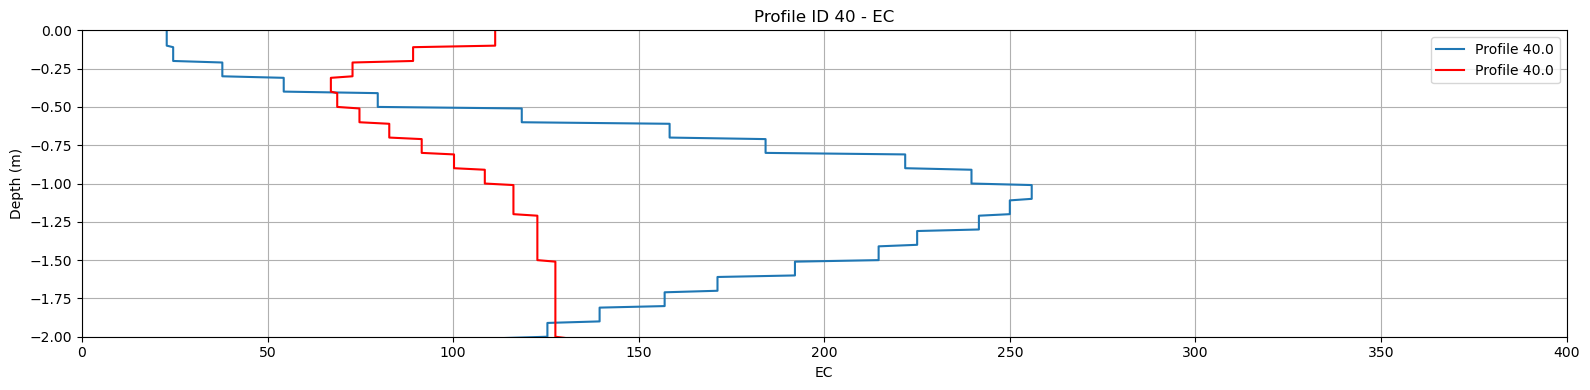

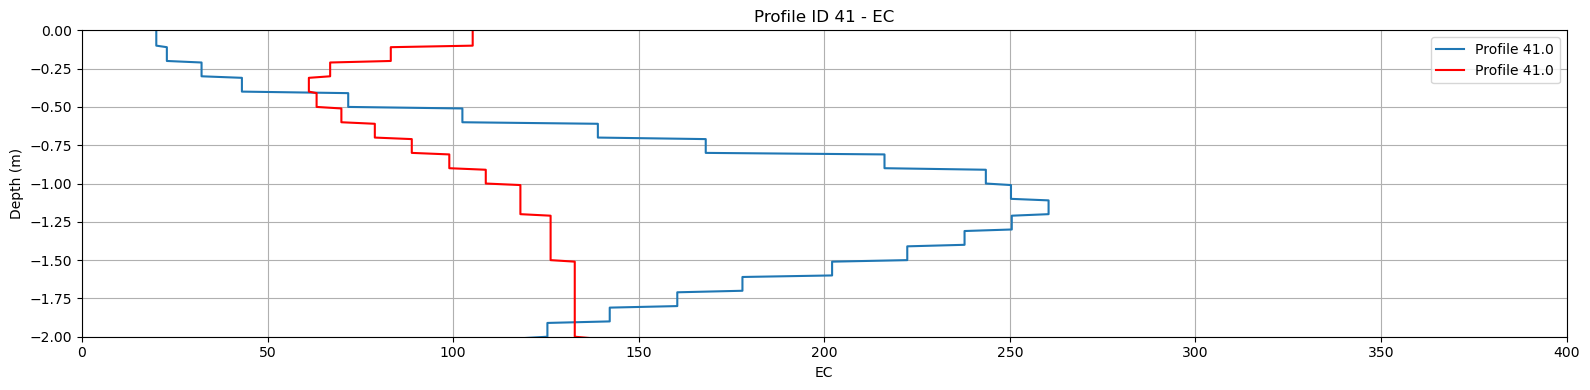

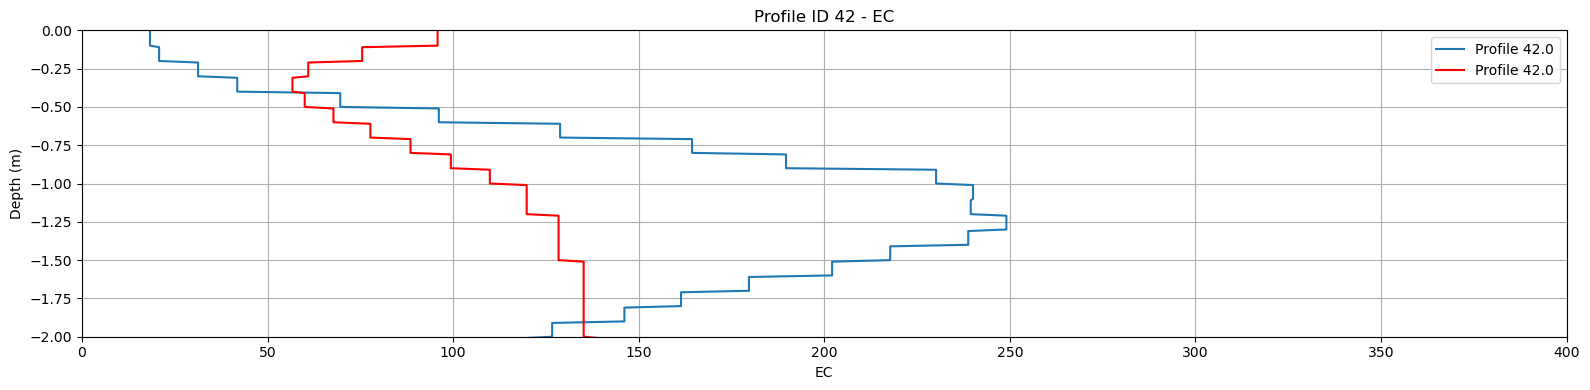

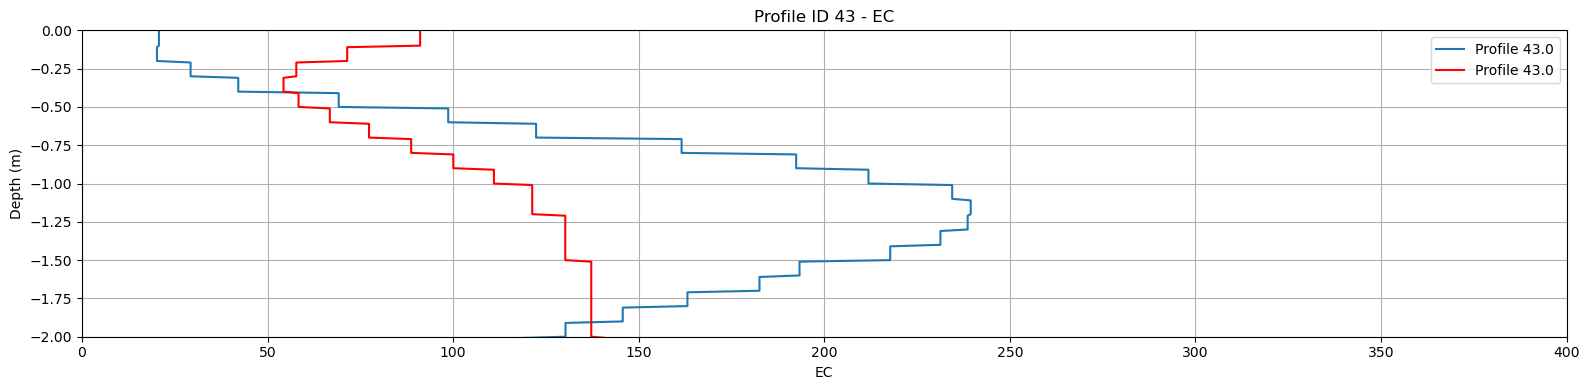

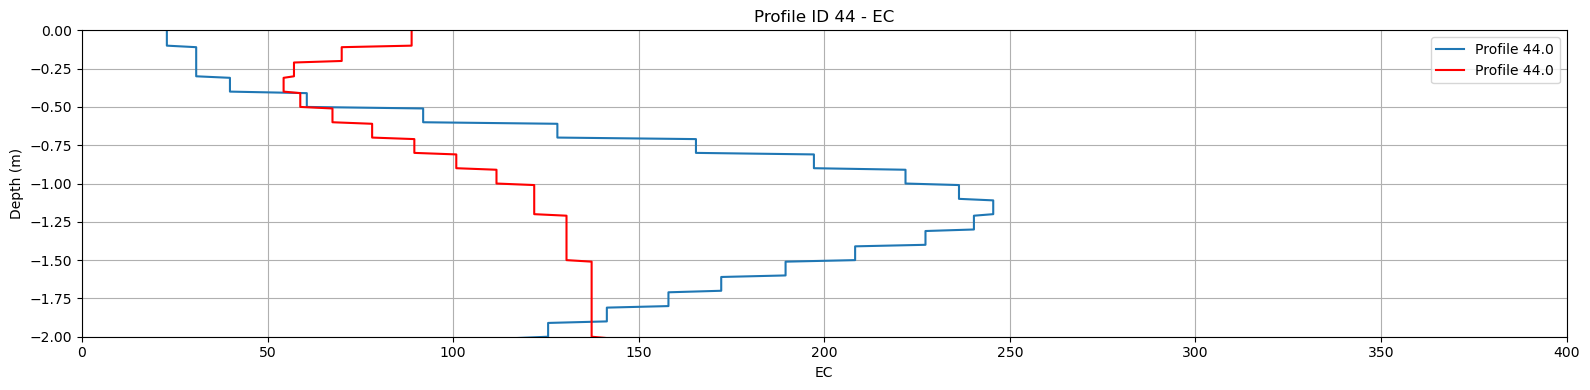

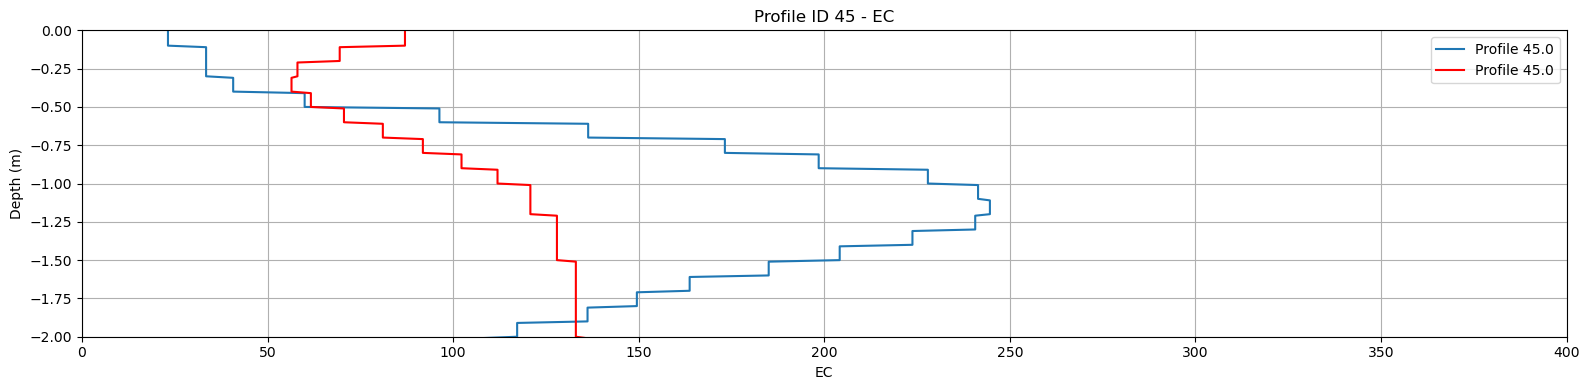

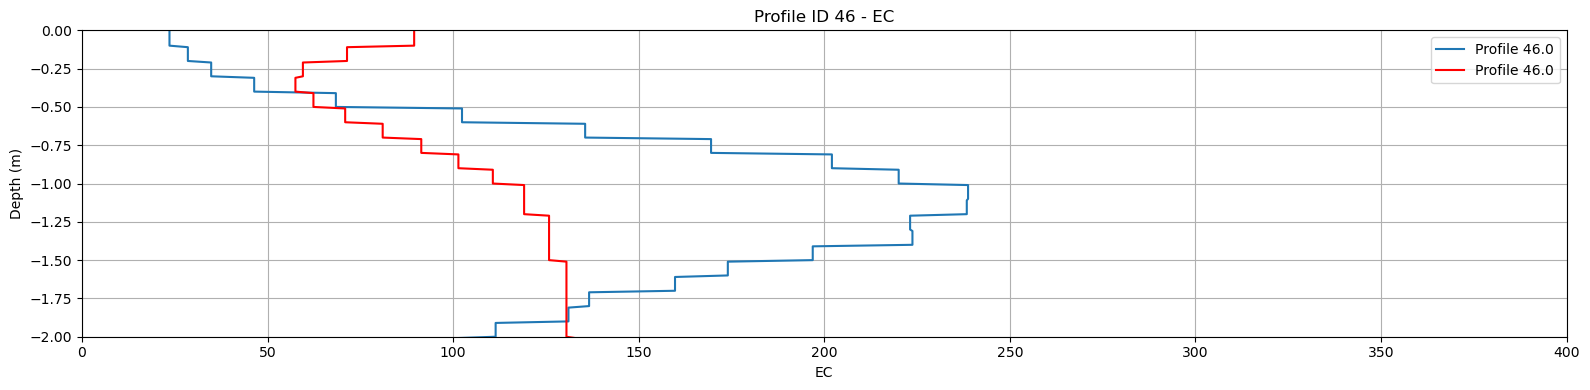

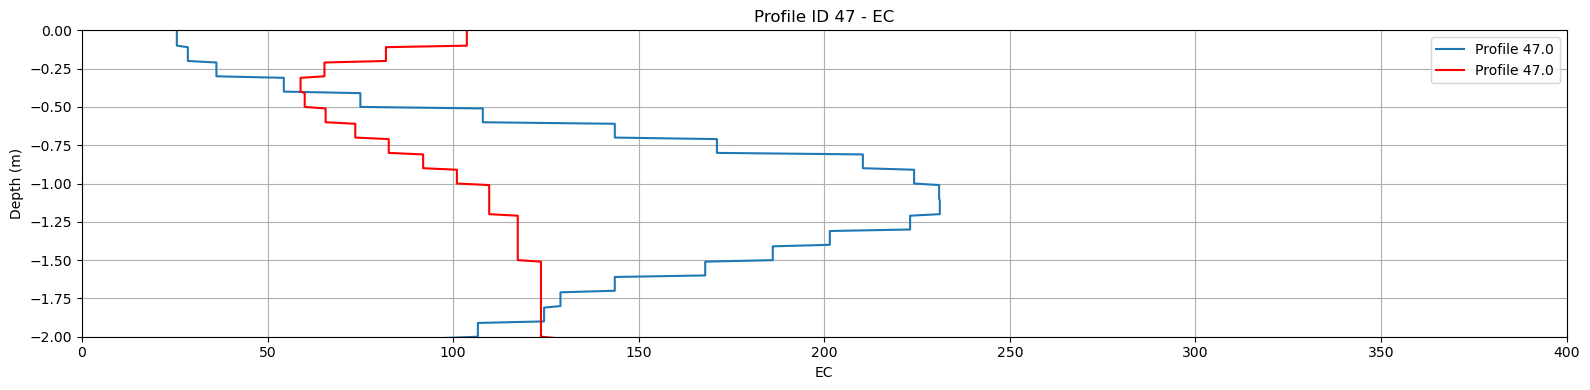

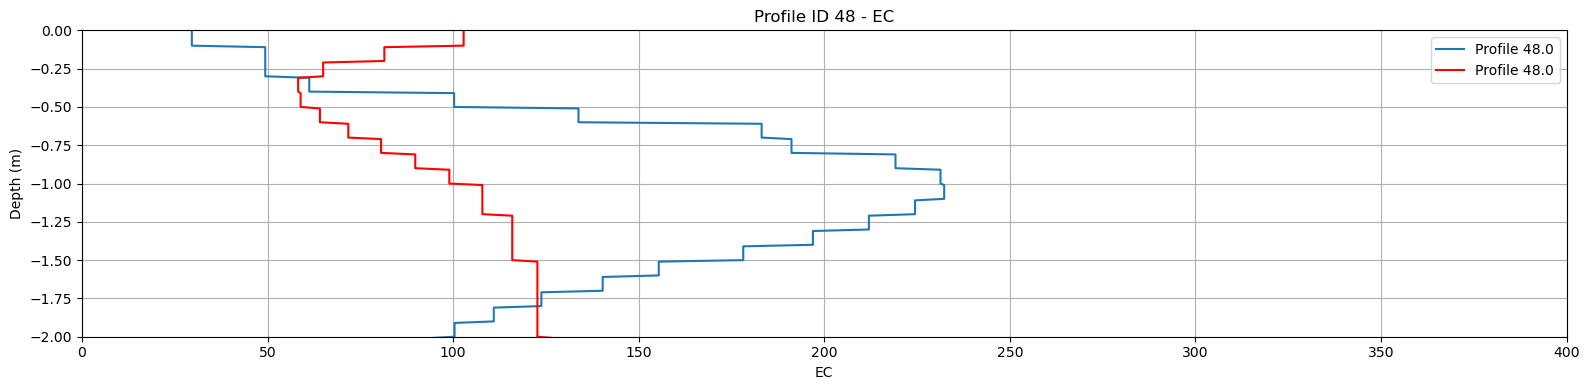

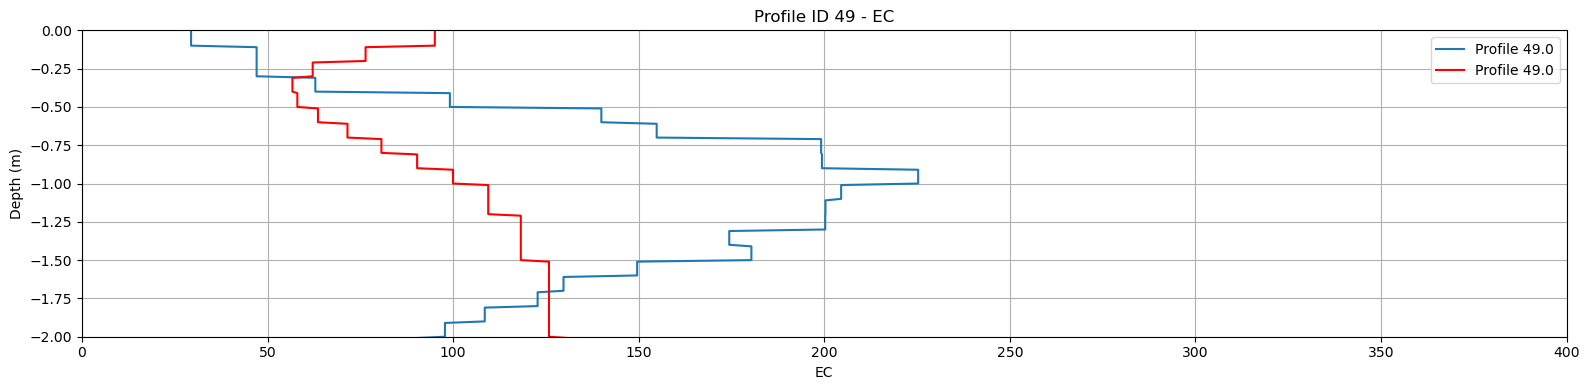

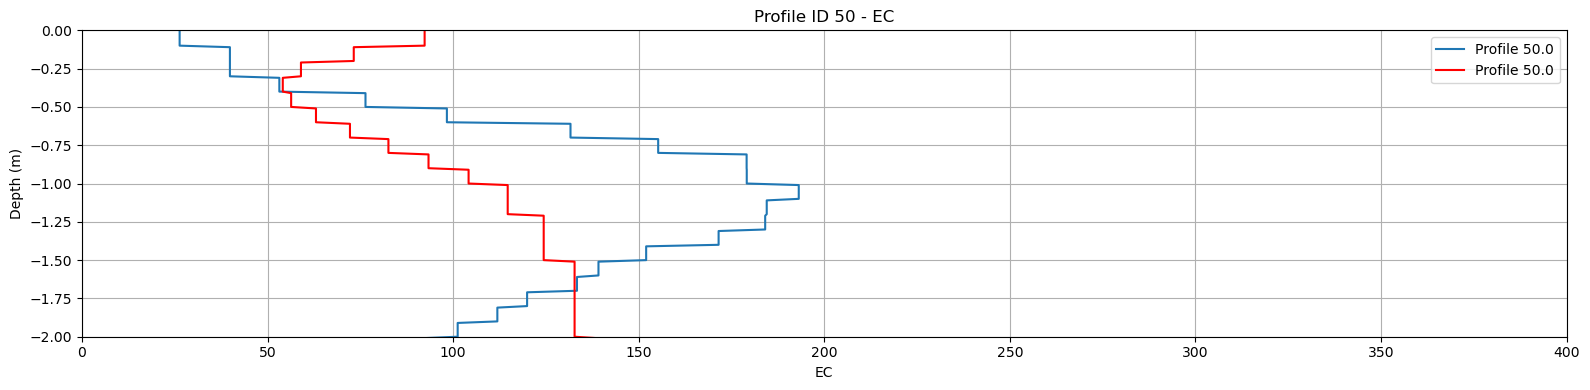

In [47]:
%autoreload

if not only_samples:
    # Function to extract depth from column name
    def extract_depth(col_name):
        if col_name.startswith('EC_'):
            return float(col_name.split('_')[1])
        return None

    # Extracting depth values and sorting them
    depth_cols = [col for col in dt_inv.columns if col.startswith('EC_')]
    depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
    depths.sort()

    # Calculate depth for 'EC_end'
    if depths:
        end_depth = depths[-1] + depths[0]
        depths.append(end_depth)

    # Creating the new DataFrame
    transformed_data = {
        'Z': [],
        'EC': [],
        'easting': [],
        'northing': [],
        'ID': []
    }

    # Populating the new DataFrame
    for _, row in dt_inv.iterrows():
        for depth, depth_col in zip(depths, depth_cols):
            transformed_data['Z'].append(-depth)
            transformed_data['EC'].append(row[depth_col])
            transformed_data['easting'].append(row['x'])
            transformed_data['northing'].append(row['y'])
            transformed_data['ID'].append(row['pos'])

    transformed_df = pd.DataFrame(transformed_data)

    pdf_files = []
    if s_site == 'P':
        xlims = (0, 400)
    elif s_site == 'M':
        xlims = (0, 800)

    for i in transformed_df['ID'].unique():
        profile_label = str(i)
        if '.0' in profile_label:
            profile_label = profile_label.split('.')[0]
        filename = plot_profile(dc_corr, i, dataset_name,
                    compare=True, compare_df = transformed_df, compare_name = 'EC',
                    xlims=xlims,
                    ylims=(-2, 0),
                    block=True,
                    save_plot = True, 
                    plot_name = f'{FM}_inversion_p{profile_label}'
                    ) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
        
        pdf_files.append(filename)

    # Merge and save PDFs
    merger = PdfMerger()
    for pdf in pdf_files:
        merger.append(pdf)
    merged_pdf_filename = f'{emfile_prefix}_inverted_transects_{cl}_{percent}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.pdf'
    outfile_transect_pdf = os.path.join(inv_folder, merged_pdf_filename)
    merger.write(outfile_transect_pdf)
    merger.close()
    for pdf in pdf_files:
        os.remove(pdf)
    clear_output(wait=False)

In [48]:
# Perform inversion on sampling locations (to be used in pedophysical modelling)

if 'code' in em_samples.columns:
    em_samples = em_samples.rename(columns={'code': 'ID'})

# if config['n_omit'] != 0:
#     unique_ids = em_input['ID'].unique()
#     print(unique_ids)
#     selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
#     em_input = em_input.loc[em_input['ID'].isin(selected_ids)]

infile_name = 'infile_s02.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
em_samples.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_samples.columns.values[n:n+i] = new_columns

em_samples.to_csv(temp_file)

# transect inversion settings

s_rec = Problem()
s_rec.createSurvey(temp_file)
#t_rec.rollingMean(window=12)

s_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=conductivities
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
    )
#print(np.flipud(mod_layers), conductivities)

#shutil.rmtree(temp_dir)

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = s_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            s_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        s_rec.removeCoil(config['coil_n'])

print(f'Data used for inversion: {s_rec.coils}')

Data used for inversion: ['HCP0.5f90000.165', 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165']


Inversion using FSeq with Gauss-Newton, reg=l2, alpha=0.07
15/15 inverted

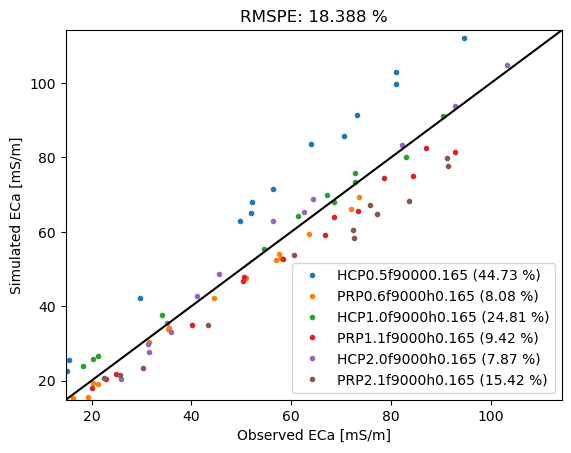

In [49]:
# invert using ROPE solver (RObust Parameter Estimation)
warnings.filterwarnings('ignore')

if MinM in ['MCMC', 'ROPE']:
    if config['constrain']:
        print(f'Constrained inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
        s_rec.invert(forwardModel = FM, method=MinM, 
                regularization=reg_meth, alpha=alpha, njobs=-1,
                bnds=bounds
                )
    else:
        print(f'Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
        s_rec.invert(forwardModel=FM, method=MinM, 
        regularization=reg_meth, alpha=alpha, njobs=-1
        )

else:
    print(f'Inversion using {FM} with {MinM}, reg={reg_meth}, alpha={alpha}')
    s_rec.invert(forwardModel=FM, method=MinM, alpha=alpha,regularization=reg_meth)
s_rec.showOne2one()

s_rec [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.2 1.5 2.  2.5 3. ]
em_samples                 x              y          z             t  HCP0.5f90000.165  \
0   107719.993789  183326.692533  26.190211  40954.666667         56.382016   
1   107755.861518  183331.121400  26.907999  42487.660000         15.378825   
2   107797.935445  183278.904873  28.459258  42818.371818         94.509676   
3   107764.402815  183318.413215  27.314691  42520.443077          6.582823   
4   107723.425371  183309.402714  26.606666  40598.470000         73.258257   
5   107742.897625  183330.125838  26.698591  41848.561250         29.667276   
6   107806.755275  183274.783715  28.633550  43144.534000         81.016875   
7   107758.592060  183312.543440  27.349757  42106.566667         14.984346   
8   107776.027790  183310.318610  27.602583  42775.448000         49.815955   
9   107726.321500  183318.837633  26.558333  40950.896667         81.055587   
10  107766.741720  183327.354060  27.183443  42857.3

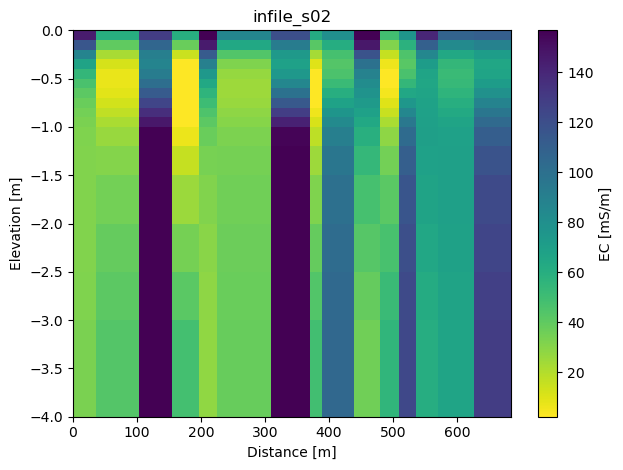

In [50]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------
csv_filename = f'{emfile_prefix}_inverted_samples_{sample_loc}_{cl}_{percent}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
s_rec.showResults(dist=True, errorbar = True) 
print('s_rec', s_rec.depths[0][0])

# Extracting the values from the first row of the transect.depths[0] array
depth_values = s_rec.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[s_rec.surveys[0].df[['x', 'y']].values, s_rec.models[0]]

# Creating the final dataframe with the desired column names
ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
print('em_samples', em_samples)
print('ds_inv', ds_inv)

ds_inv['pos'] = em_samples['ID'].to_numpy()
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
outfile_transect = os.path.join(inv_folder, csv_filename)
ds_inv.to_csv(outfile_transect)

               x              y     EC_0.10     EC_0.20     EC_0.30  \
0  107719.993789  183326.692533  144.693403  115.145139   87.054406   
1  107755.861518  183331.121400   60.036579   40.197171   22.559446   
2  107797.935445  183278.904873  129.230414  106.037386   90.479097   
3  107764.402815  183318.413215   59.777034   37.399510   14.556696   
4  107723.425371  183309.402714  179.660370  145.289308  112.717921   

     EC_0.40    EC_0.50     EC_0.60     EC_0.70     EC_0.80     EC_0.90  \
0  67.378527  54.668058   46.547206   41.274550   37.753799   35.325056   
1  12.083751   7.595509    7.131585    9.158641   12.644188   16.927070   
2  87.140845  92.219092  101.770782  113.181755  124.943184  136.256856   
3  -2.005151 -11.864233  -16.185047  -16.278627  -13.257451   -7.991293   
4  89.757016  74.485315   64.066741   56.508985   50.614964   45.704768   

      EC_1.00     EC_1.20     EC_1.50     EC_2.00     EC_2.50     EC_3.00  \
0   33.595977   32.333382   31.640649   31.43

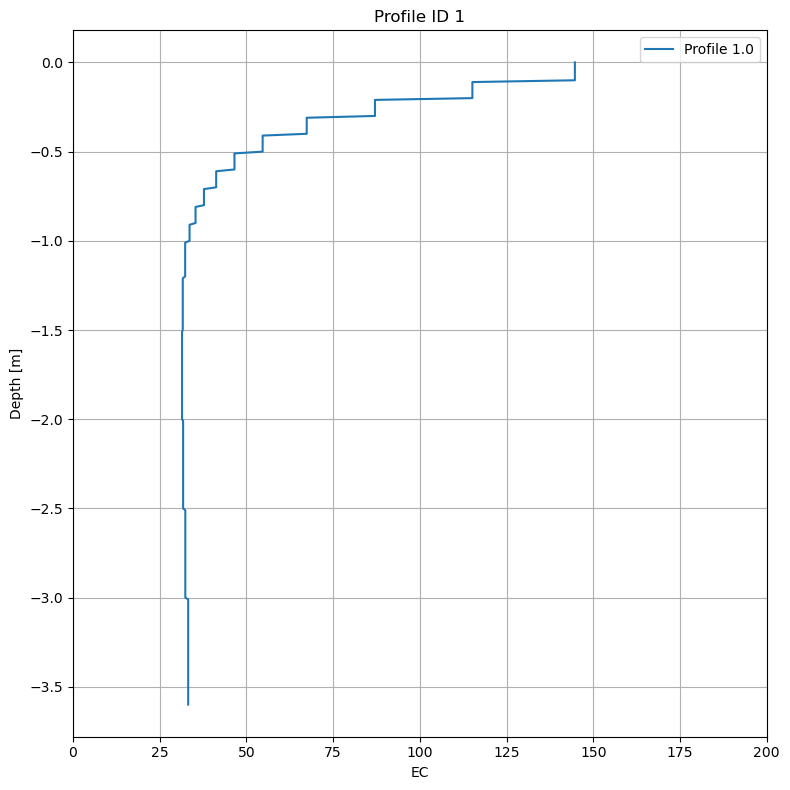

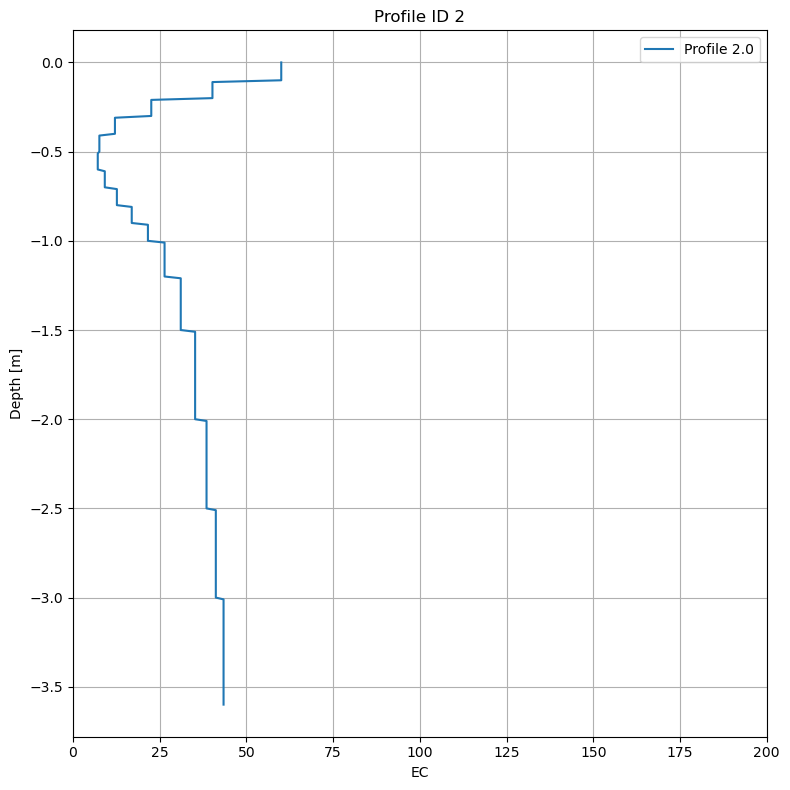

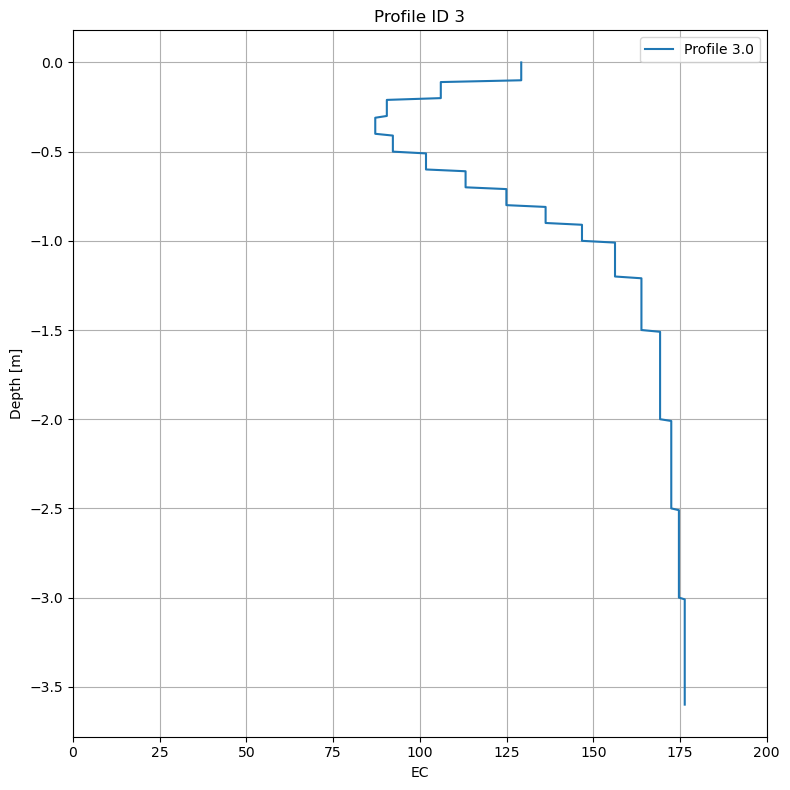

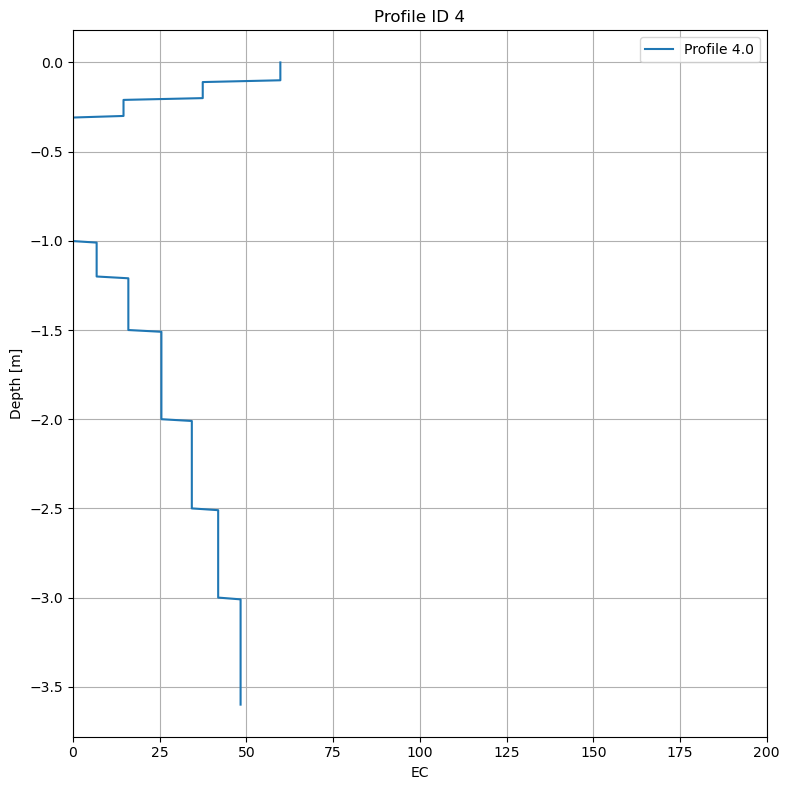

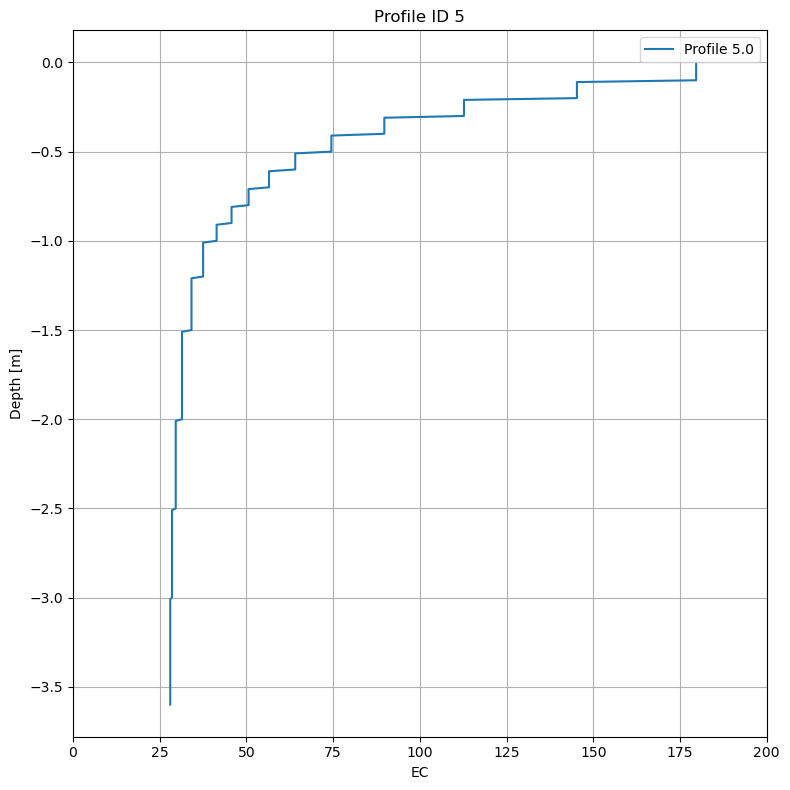

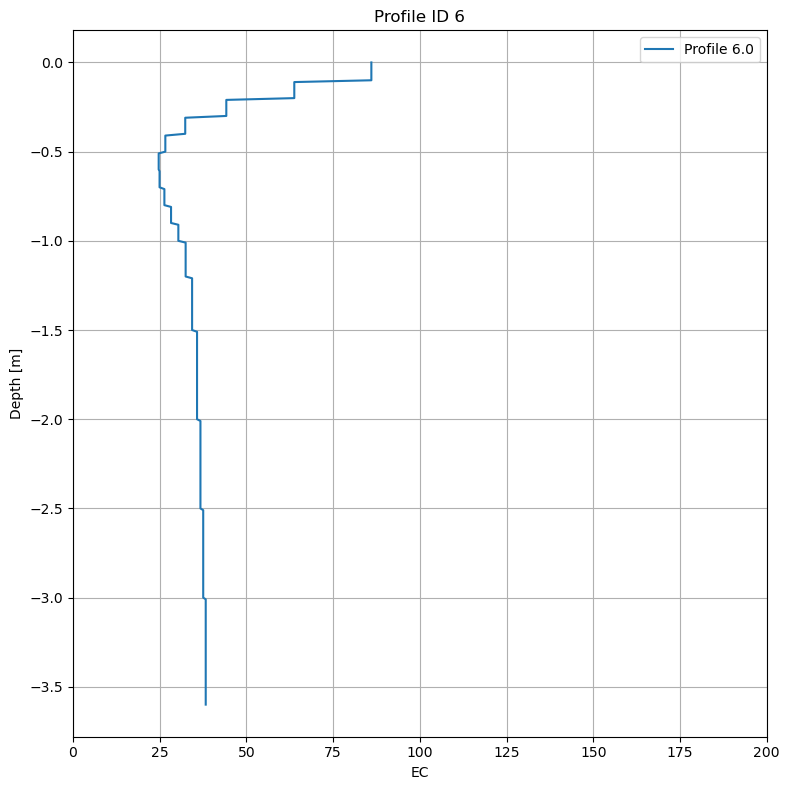

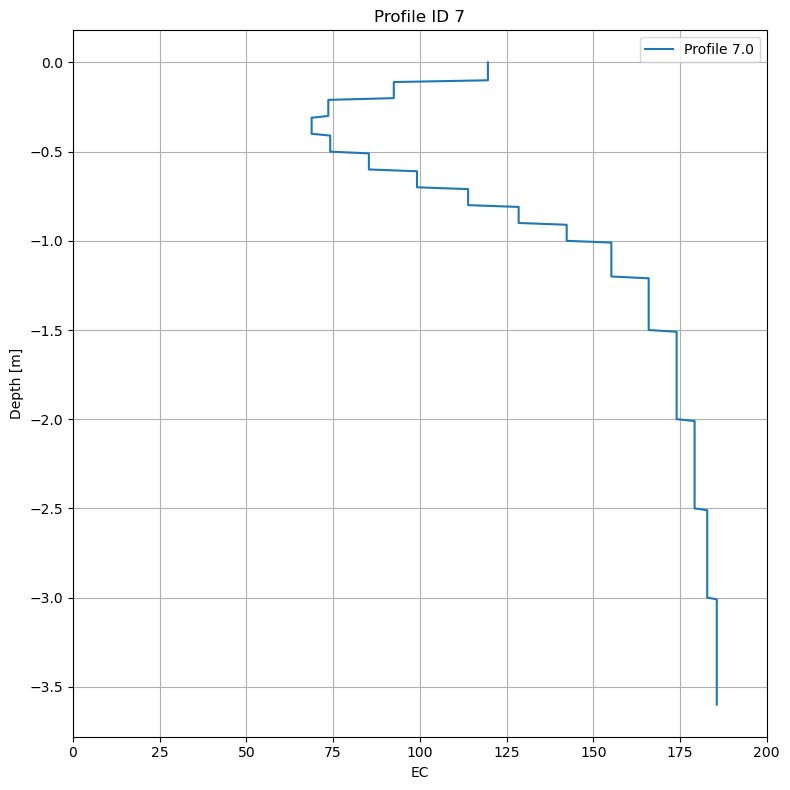

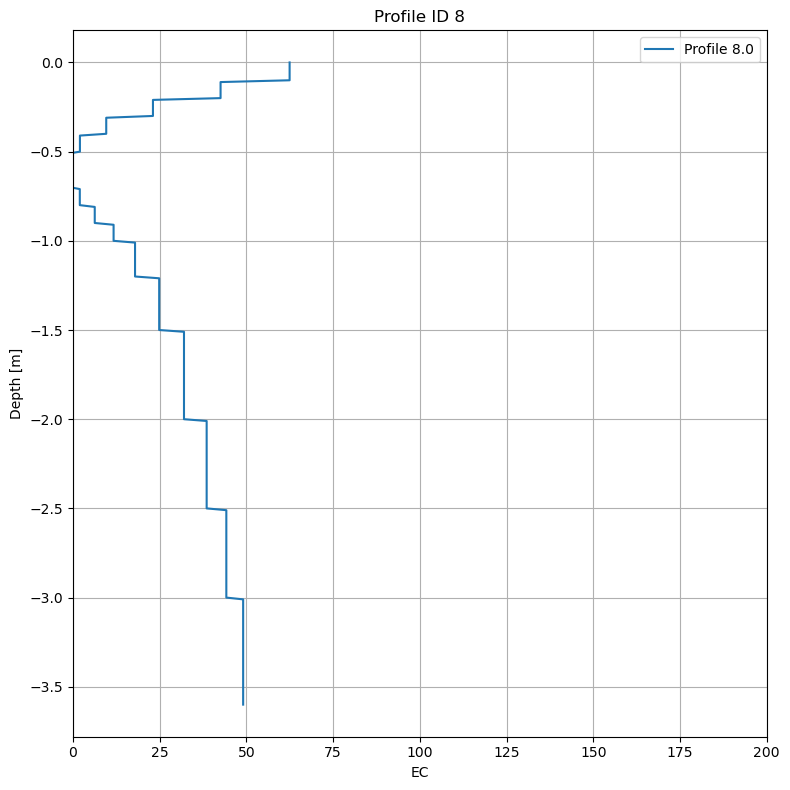

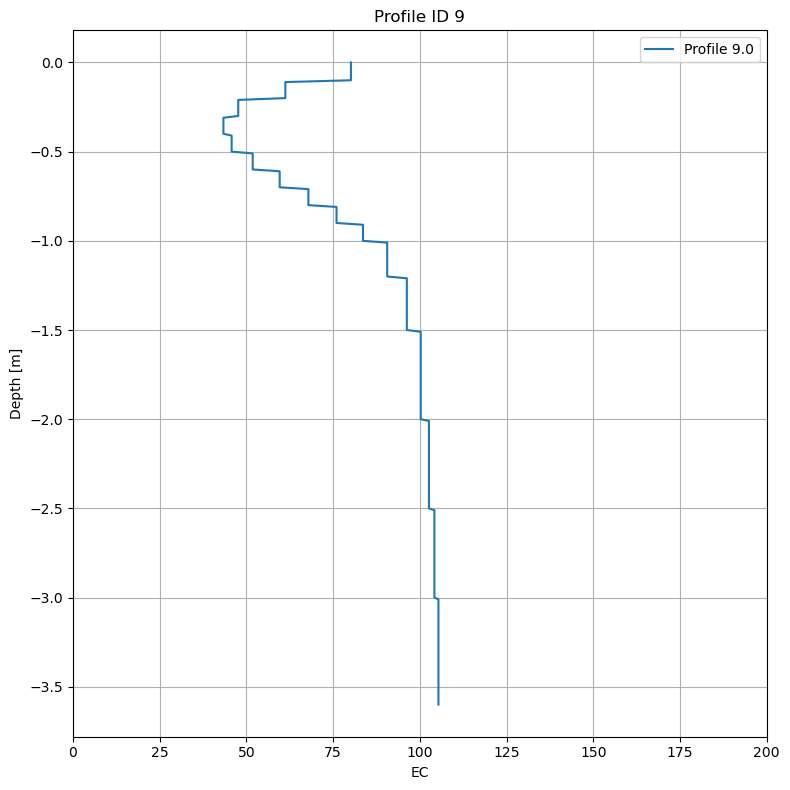

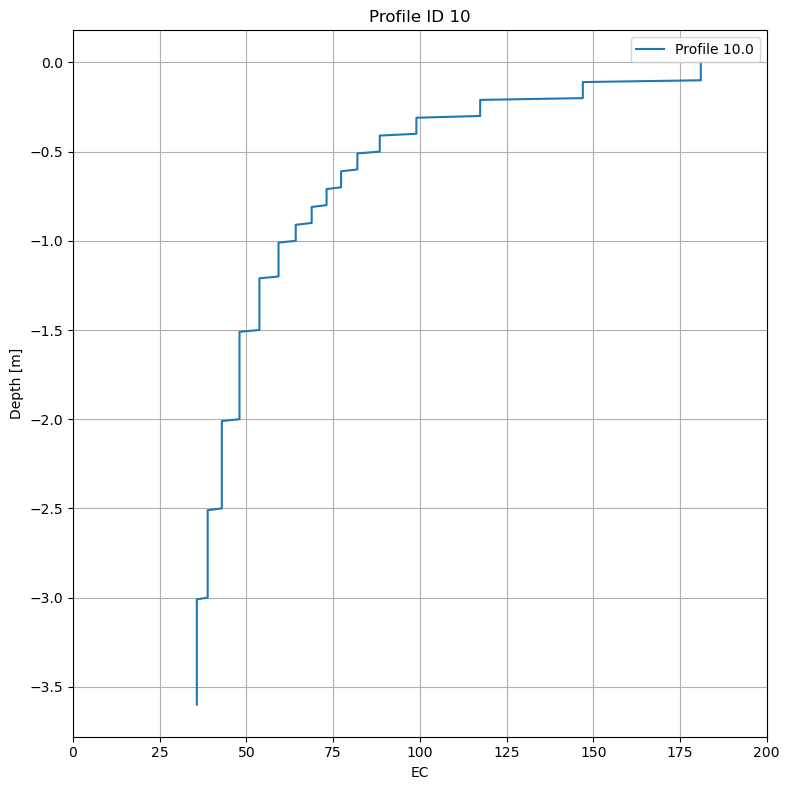

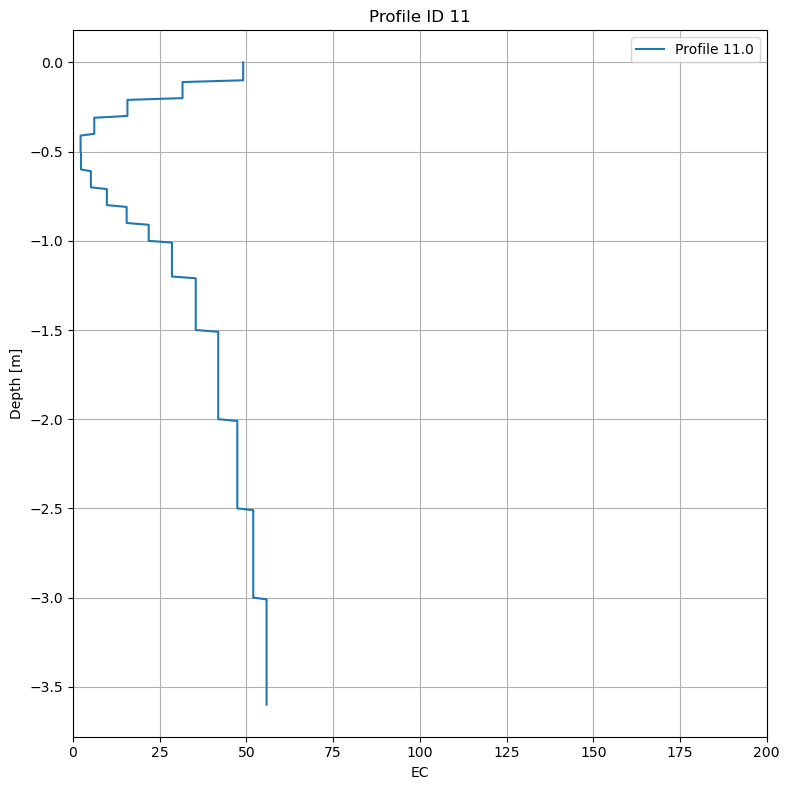

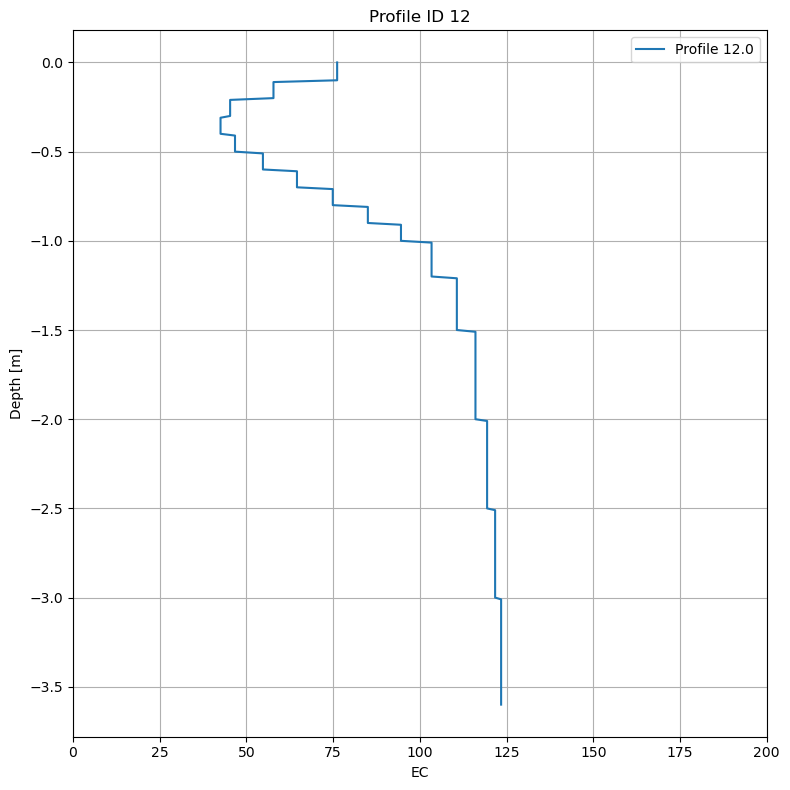

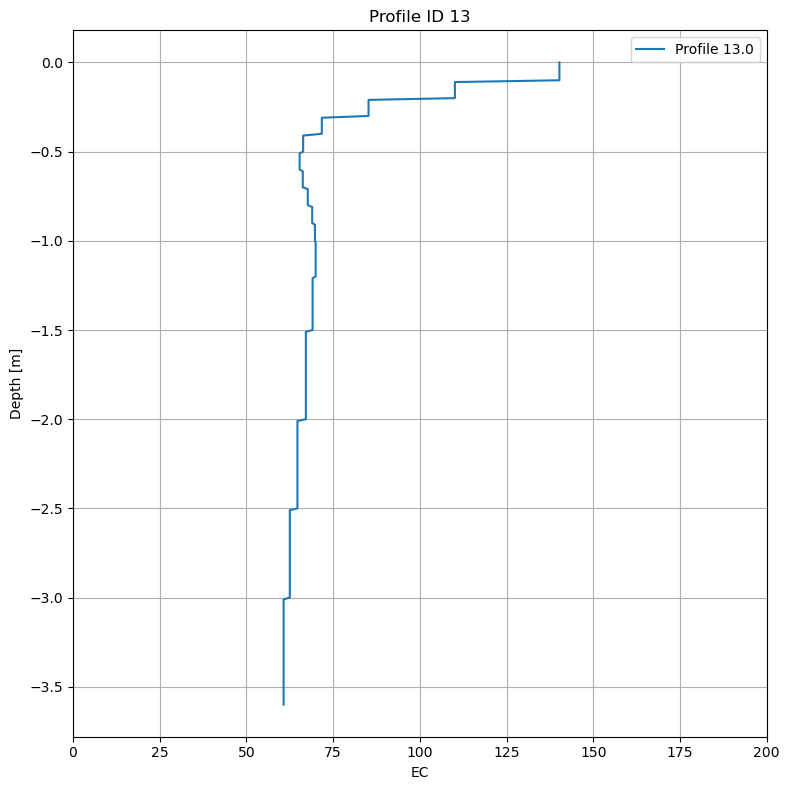

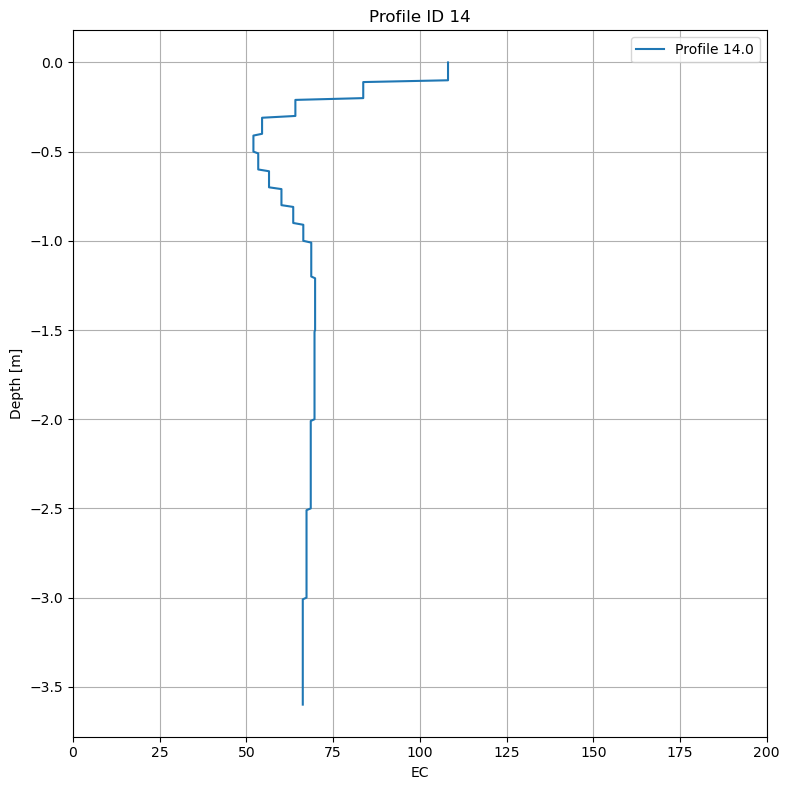

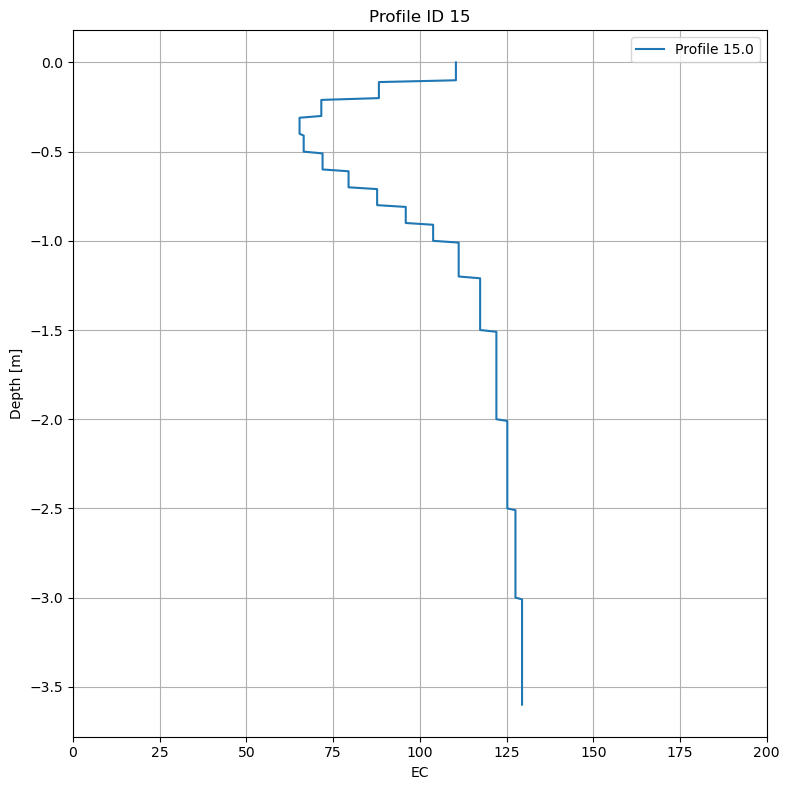

In [51]:
%autoreload
# Function to extract depth from column name
def extract_depth(col_name):
    if col_name.startswith('EC_'):
        return float(col_name.split('_')[1])
    return None

# Extracting depth values and sorting them
depth_cols = [col for col in ds_inv.columns if col.startswith('EC_')]
depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
depths.sort()

# Calculate depth for 'EC_end'
if depths:
    end_depth = depths[-1] + depths[0]
    depths.append(end_depth)

# Creating the new DataFrame
transformed_data = {
    'Z': [],
    'EC': [],
    'easting': [],
    'northing': [],
    'ID': []
}

# Populating the new DataFrame
for _, row in ds_inv.iterrows():
    for depth, depth_col in zip(depths, depth_cols):
        transformed_data['Z'].append(-depth)
        transformed_data['EC'].append(row[depth_col])
        transformed_data['easting'].append(row['x'])
        transformed_data['northing'].append(row['y'])
        transformed_data['ID'].append(row['pos'])

transformed_df = pd.DataFrame(transformed_data)

pdf_files = []
for i in transformed_df['ID'].unique():
    profile_label = str(i)
    if '.0' in profile_label:
        profile_label = profile_label.split('.')[0]
    filename = plot_profile(transformed_df, i, 'EC', xlims=(0,200),
                 block=True,
                 save_plot = True, 
                 plot_name = f'{FM}_inversion_p{profile_label}'
                 ) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
    
    pdf_files.append(filename)

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merged_pdf_filename = f'{emfile_prefix}_{cl}_{percent}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}_samples.pdf'

outfile_samples_pdf = os.path.join(inv_folder, merged_pdf_filename)
merger.write(outfile_samples_pdf)
merger.close()
for pdf in pdf_files:
    os.remove(pdf)
clear_output(wait=False)

print(ds_inv.head())

In [52]:
#filename = f'{emfile_prefix}_{cl}_{percent}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}_parameters.json'
#filepath = os.path.join(inv_folder,filename)
#file = open(filepath, 'w')

#file.write('\t"input file + path": "{}",'.format(infile) + '\n\n')
#file.write('\t"instrument": "{}",'.format(config['instrument_code'] ) + '\n')
#file.write('\t"instrument mode": "{}",'.format(config['instrument_orientation']) + '\n')
#file.write('\t"instrument height (m)": {:.3f},'.format(config['instrument_height']) + '\n')

#if config['remove_coil']:
#    rem_coils = instrument.cc_names[config['coil_n']]
#    file.write('\t"configurations not used in inversion": "{}",'.format(rem_coils) + '\n\n')

#file.write('\t"forward model": "{}",'.format(FM) + '\n')
#file.write('\t"minimization method":"{}",'.format(config['MinM']) + '\n')
#file.write('\t"regularisation": "{}",'.format(config['regularization']) + '\n')
#file.write('\t"alpha parameter": "{}",'.format(alpha) + '\n\n')
#file.write('\t"reference EC profile":"{}",'.format(config['reference_profile']) + '\n')

#if config['constrain']:
#    file.write('\t "constrained inversion":' + '\n')
#    if config['n_int']:
#        file.write('\t"custom interface boundaries": "{}"\n'.format(config['interface']) + '\n')
#    if config['custom_bounds']:
#        file.write('\t"custom inversion constraints (bnds)": "{}" \n'.format(config['bounds']) + '\n')
#    else:
#        file.write('\t"automated inversion constraints (bnds)": "{}"\n'.format(bounds) + '\n')
#file.close()

In [53]:
datafolder = 'data/inverted' # data folder
mdk = os.path.join(datafolder, f'samps_all_middelkerke_421S_inverted_samples_{cl}_{percent}_{sample_loc}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv')
ph = os.path.join(datafolder, f'samps_all_proefhoeve_21HS_inverted_samples_{cl}_{percent}_{sample_loc}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv')

M_df = pd.read_csv(mdk, sep=',', header=0)
P_df = pd.read_csv(ph, sep=',', header=0)
f6(M_df, P_df)

FileNotFoundError: [Errno 2] No such file or directory: 'data/inverted\\samps_all_middelkerke_421S_inverted_samples_0.3_20_mean_FSeq_Gauss-Newton_0.07_False_True_False.csv'